# Проектная работа по курсу Big Data (Горохов, ПМИ 433)

## Описание проекта

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Импорт библиотек

In [458]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузка данных

In [459]:
data = pd.read_csv('./real_estate_data.csv', sep='\t')
print(data.head())

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

In [460]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Вывод: Датасет содержит данные по 23699 объектам недвижимости, каждый из которых описывается 22 переменными (17 количественных, 4 категориальных и 1 временной). В некоторых переменных есть пропущенные значения.

### Предобработка данных

#### Обработка пропущенных значений

In [461]:
percent_missing = round(data.isnull().sum() * 100 / len(data), 1)  # процент пропущенных значений по каждому признаку
print(percent_missing)

total_images             0.0
last_price               0.0
total_area               0.0
first_day_exposition     0.0
rooms                    0.0
ceiling_height          38.8
floors_total             0.4
living_area              8.0
floor                    0.0
is_apartment            88.3
studio                   0.0
open_plan                0.0
kitchen_area             9.6
balcony                 48.6
locality_name            0.2
airports_nearest        23.4
cityCenters_nearest     23.3
parks_around3000        23.3
parks_nearest           65.9
ponds_around3000        23.3
ponds_nearest           61.6
days_exposition         13.4
dtype: float64


In [462]:
# функция для вывода на экран процента пропущенных значений по указанному признаку
def percent_missing_out(col_name):
    print('Пропущено {}%'.format(percent_missing[col_name]) + ' значений')

1. Число этажей (foolrs_total)

In [463]:
percent_missing_out('floors_total')

Пропущено 0.4% значений


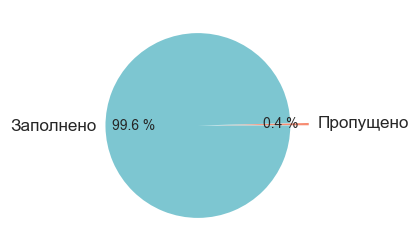

In [618]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['floors_total'], 100 - percent_missing['floors_total']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

In [464]:
data.dropna(subset=['floors_total'], inplace=True)  # удаление строк с пропусками числа этажей
print(data['floors_total'].isna().value_counts())

False    23613
Name: floors_total, dtype: int64


Удалено 86 строк, содержащих пропуски по данной переменной.

Вывод: Было пропущено 0,4% значений. Пропуски данного признака являются полностью случайными, восстановить пропущенные данные не представляется возможным. Необходимо заполнять пропуски по данному признаку на основе адреса объекта недвижимости. Так как процент пропусков в данной колонке очень мал, то удаление строк с пропусками в данной колонке не повлияет на общее представление данных и последующий анализ.

2. Высота потолков (ceiling_height)

In [465]:
percent_missing_out('ceiling_height')

Пропущено 38.8% значений


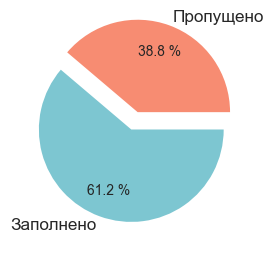

In [617]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['ceiling_height'], 100 - percent_missing['ceiling_height']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

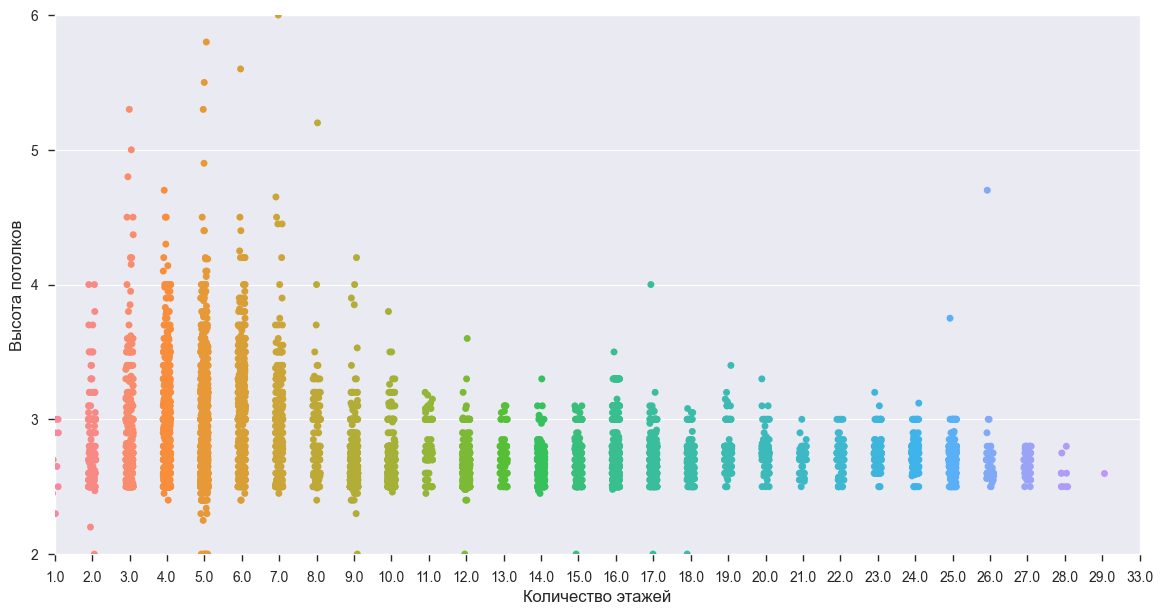

In [466]:
plt.figure(figsize=(14, 7))
sns.stripplot(x='floors_total', y='ceiling_height', data=data, jitter=True)
plt.xlabel('Количество этажей', fontsize=12)
plt.ylabel('Высота потолков', fontsize=12)
plt.xticks(np.arange(0, max(data['floors_total']) + 1, 1), fontsize=10)
plt.yticks(np.arange(min(data['ceiling_height']), max(data['ceiling_height']) + 1, 1), fontsize=10)
plt.xlim([0, 29])
plt.ylim([2, 6])
plt.show()

In [467]:
ceiling_medians = data.pivot_table(index='floors_total',
                                   values='ceiling_height',
                                   aggfunc='median')
print(ceiling_medians.head())  # медианные значения высоты потолков для объектов недвижимости с соответствующим числом этажей

              ceiling_height
floors_total                
1.0                     2.80
2.0                     2.70
3.0                     2.80
4.0                     3.00
5.0                     2.55


In [468]:
# заполнение пропусков высоты потолков медианными значениями высот для объектов недвижимости с соответствующим числом этажей
for nfloors in ceiling_medians.index:
        data.loc[(data['ceiling_height'].isna()) & (data['floors_total'].isin(ceiling_medians.index)),
                 'ceiling_height'] = ceiling_medians.loc[nfloors, 'ceiling_height']
        data.loc[(data['ceiling_height'].isna()) & ~(data['floors_total'].isin(ceiling_medians.index)),
                 'ceiling_height'] = data['ceiling_height'].median()

In [469]:
print(data['ceiling_height'].isna().value_counts())

False    23613
Name: ceiling_height, dtype: int64


Вывод: Было пропущено 38,8% значений. Пропуски данного признака являются случайными. Был выбран способ заполнения медианными значениями для зданий с конкретным числом этажей (либо общим медианым значением для зданий, которые являются единственным экземпляром по своему числу этажей в датасете (и, соответственно, имеют только пропущенное значение высоты потолков)). Кроме того, часть значений в данном столбце заполнена с ошибкой (есть грубые ошибки в данных). Необходимо добавить ограничение на допустимые значения высоты потолков (например, меньше 10 и больше 2,5 метров).

3. Жилая площадь (living_area)

In [470]:
percent_missing_out('living_area')

Пропущено 8.0% значений


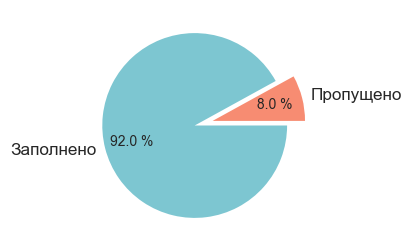

In [619]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['living_area'], 100 - percent_missing['living_area']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

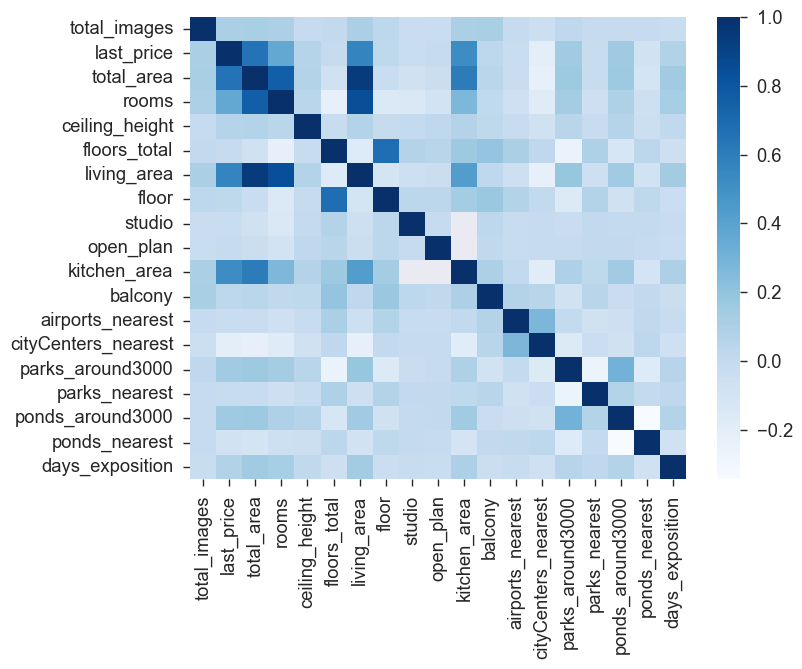

In [471]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), cmap='Blues')
plt.show()

Гипотеза: Жилая площадь объекта недвижимости зависит от общей площади объекта. Проверим данную гипотезу.

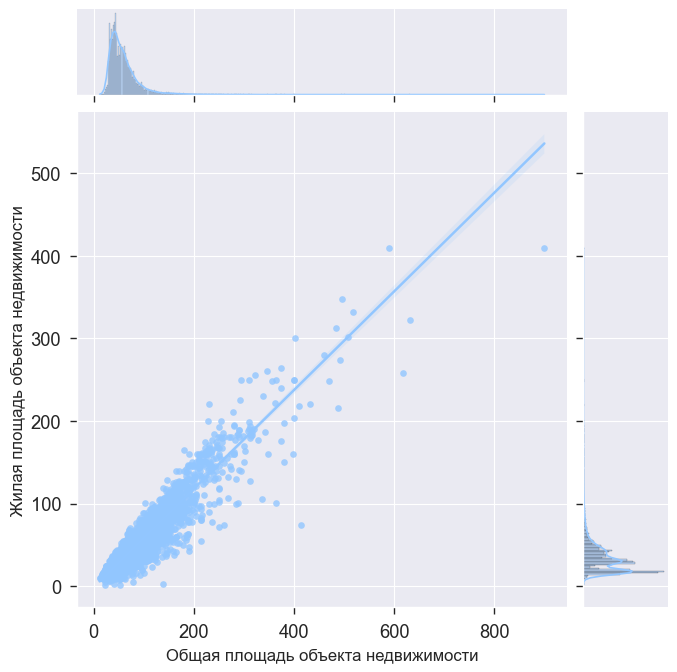

In [472]:
larea_tarea_lm = sns.jointplot(x='total_area', y='living_area', data=data, kind='reg', height=7)
larea_tarea_lm.set_axis_labels('Общая площадь объекта недвижимости', 'Жилая площадь объекта недвижимости', fontsize=12)
plt.show()

In [473]:
# удаление пропусков в переменной, содержащей общую площадь недвижимости
living_area_cleaned = data.loc[~(data['living_area'].isna()), ['total_area', 'living_area']].reset_index(drop=True)
print(living_area_cleaned.head())

   total_area  living_area
0       108.0         51.0
1        40.4         18.6
2        56.0         34.3
3       100.0         32.0
4        30.4         14.4


In [474]:
# построение линейной регрессионной модели зависимости жилой площади от общей площади объекта недвижимости
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(living_area_cleaned[['total_area']].values, living_area_cleaned['living_area'].values)
living_area_pred = lm.predict(living_area_cleaned[['total_area']])  # предсказанные значения
print('Коэффициент регрессии: {:.2f}'.format(lm.coef_[0]))
print('Свободный член: {:.2f}'.format(lm.intercept_))

Коэффициент регрессии: 0.60
Свободный член: -1.41


D:\Programs\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [475]:
# замена пропущенных значений переменной, содержащей размеры жилой площади объекта недвижимости, по построенной модели
data.loc[data['living_area'].isna(), 'living_area'] = \
    lm.coef_[0] + lm.intercept_ * data.loc[data['living_area'].isna(), 'total_area']

In [476]:
print(data['living_area'].isna().value_counts())

False    23613
Name: living_area, dtype: int64


Вывод: Было пропущено 8% значений. Выявлена линейная зависимость жилой площади от общей площади объекта недвижимости, а также построена регрессионная модель данной зависимости, на основе которой были заполнены пропуски по переменной, содержащей размеры жилой площади объектов недвижимости.

4. Площадь кухни (kitchen_area)

In [477]:
percent_missing_out('kitchen_area')

Пропущено 9.6% значений


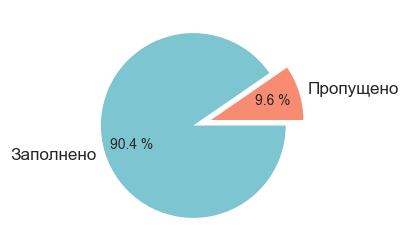

In [620]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['kitchen_area'], 100 - percent_missing['kitchen_area']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

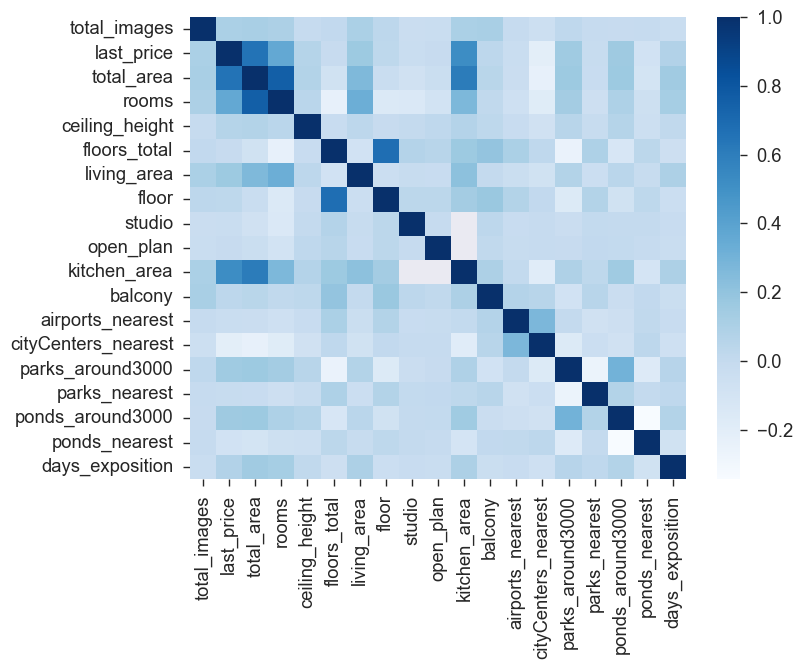

In [478]:
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), cmap='Blues')
plt.show()

Гипотеза: Площадь кухни объекта недвижимости зависит от общей площади объекта. Проверим данную гипотезу.

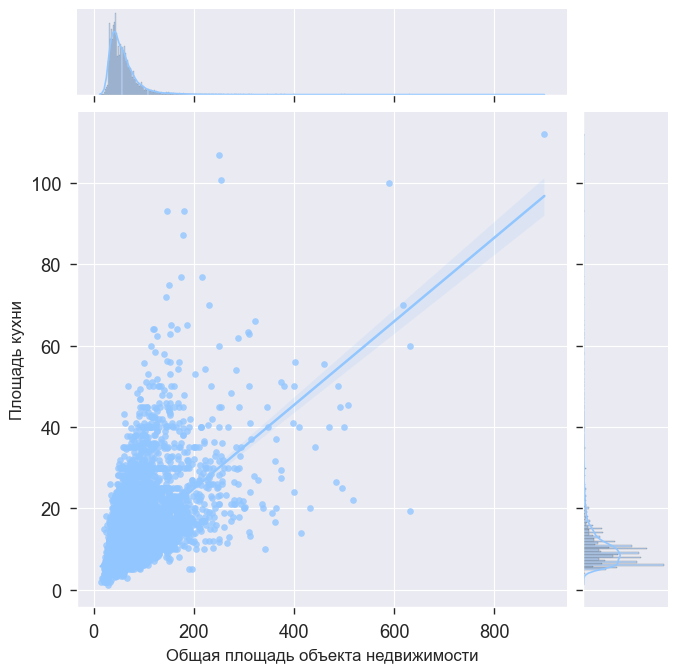

In [479]:
karea_tarea_lm = sns.jointplot(x='total_area', y='kitchen_area', data=data, kind='reg', height=7)
karea_tarea_lm.set_axis_labels('Общая площадь объекта недвижимости', 'Площадь кухни', fontsize=12)
plt.show()

In [480]:
# удаление пропусков в переменной, содержащей площадь кухни
kitchen_area_cleaned = data.loc[~(data['kitchen_area'].isna()), ['total_area', 'kitchen_area']].reset_index(drop=True)
print(kitchen_area_cleaned.head())

   total_area  kitchen_area
0       108.0          25.0
1        40.4          11.0
2        56.0           8.3
3       100.0          41.0
4        30.4           9.1


In [481]:
# построение линейной регрессионной модели зависимости площади кухни от общей площади объекта недвижимости
lm_k = LinearRegression()
lm_k.fit(kitchen_area_cleaned[['total_area']].values, kitchen_area_cleaned['kitchen_area'].values)
kitchen_area_pred = lm_k.predict(kitchen_area_cleaned[['total_area']])  # предсказанные значения
print('Коэффициент регрессии: {:.2f}'.format(lm_k.coef_[0]))
print('Свободный член: {:.2f}'.format(lm_k.intercept_))

Коэффициент регрессии: 0.10
Свободный член: 4.32


D:\Programs\Python\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


In [482]:
# замена пропущенных значений переменной, содержащей размеры площади кухни объекта недвижимости, по построенной модели
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = \
    lm_k.coef_[0] + lm_k.intercept_ * data.loc[data['kitchen_area'].isna(), 'total_area']

In [483]:
print(data['kitchen_area'].isna().value_counts())

False    23613
Name: kitchen_area, dtype: int64


Вывод: Было пропущено 9,6% значений. Выявлена линейная зависимость площади кухни от общей площади объекта недвижимости, а также построена регрессионная модель данной зависимости, на основе которой были заполнены пропуски по переменной, содержащей значения площади кухни объектов недвижимости.

5. Число балконов (balcony)

In [484]:
percent_missing_out('balcony')

Пропущено 48.6% значений


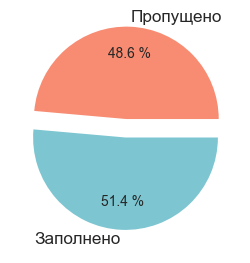

In [621]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['balcony'], 100 - percent_missing['balcony']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

In [485]:
data['balcony'].fillna(0, inplace=True)  # замена пропущенных значений нулями

In [486]:
print(data['balcony'].isna().value_counts())

False    23613
Name: balcony, dtype: int64


Вывод: Было пропущено 48,6% значений. Пропуски по данному признаку были заменены на нули. Это исходит из преположения о том, что если человек не указал число балконов, то, скорее всего, их нет.

6. Название населенного пункта (locality_name)

In [487]:
percent_missing_out('locality_name')

Пропущено 0.2% значений


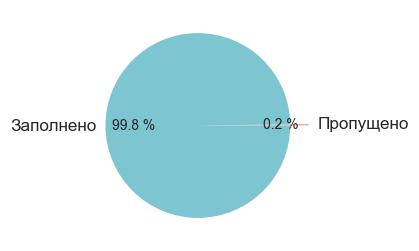

In [622]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['locality_name'], 100 - percent_missing['locality_name']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

In [488]:
data.dropna(subset=['locality_name'], inplace=True)  # удаление строк с пропусками названия населенного пункта
print(data['locality_name'].isna().value_counts())

False    23565
Name: locality_name, dtype: int64


Удалено 48 строк, содержащих пропуски по данной переменной.

Вывод: Было пропущено 0,2% значений. Пропуски данного признака являются полностью случайными, восстановить пропущенные данные не представляется возможным. Необходимо сделать обязательным заполнение данного признака в объявлении. Так как процент пропусков в данной колонке очень мал, то удаление строк с пропусками в данной колонке не повлияет на общее представление данных и последующий анализ.

7. Расстояние до центра города (cityCenters_nearest)

In [489]:
percent_missing_out('cityCenters_nearest')

Пропущено 23.3% значений


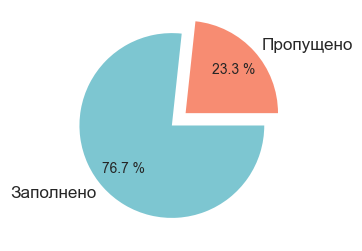

In [623]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['cityCenters_nearest'], 100 - percent_missing['cityCenters_nearest']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Вывод: Пропущено 23,3% значений. Процент пропущенных значений по данному признаку в целом велик - удалять строки, содержащие пропуски, нельзя. Однако заполнить пропущены значения не представляется возможным, поскольку в данном случае для этого требуются большие трудозатраты (значения по этому признаку заполняются на основе картографических данных). Оставляем данные без изменений.

8. Аппартаменты (is_apartment)

In [490]:
percent_missing_out('is_apartment')

Пропущено 88.3% значений


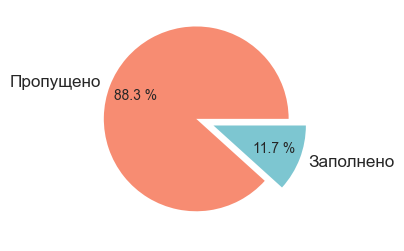

In [624]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['is_apartment'], 100 - percent_missing['is_apartment']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Оставляем данные без изменений, поскольку для заполнения пропусков в данной переменной требуются большие трудозатраты. Для дальнейшего анализа эти данные использоваться не будут.

9. Расстояние до ближайшего аэропорта (airports_nearest)

In [491]:
percent_missing_out('airports_nearest')

Пропущено 23.4% значений


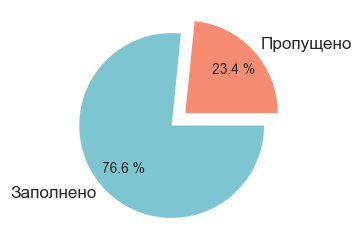

In [625]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['airports_nearest'], 100 - percent_missing['airports_nearest']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Оставляем данные без изменений, поскольку для заполнения пропусков в данной переменной требуются большие трудозатраты (значения по этому признаку заполняются на основе картографических данных). Для дальнейшего анализа эти данные использоваться не будут.

10. Число парков в радиусе 3 км (parks_around3000)

In [492]:
percent_missing_out('parks_around3000')

Пропущено 23.3% значений


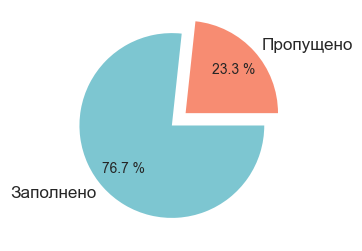

In [626]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['parks_around3000'], 100 - percent_missing['parks_around3000']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Оставляем данные без изменений, поскольку для заполнения пропусков в данной переменной требуются большие трудозатраты (значения по этому признаку заполняются на основе картографических данных). Для дальнейшего анализа эти данные использоваться не будут.

11. Расстояние до ближайшего парка (parks_nearest)

In [493]:
percent_missing_out('parks_nearest')

Пропущено 65.9% значений


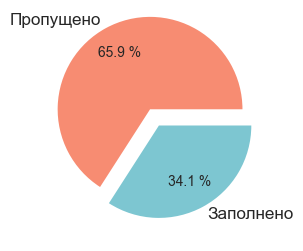

In [627]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['parks_nearest'], 100 - percent_missing['parks_nearest']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Оставляем данные без изменений, поскольку для заполнения пропусков в данной переменной требуются большие трудозатраты (значения по этому признаку заполняются на основе картографических данных). Для дальнейшего анализа эти данные использоваться не будут.

12. Число водоемов в радиусе 3 км (ponds_around3000)

In [494]:
percent_missing_out('ponds_around3000')

Пропущено 23.3% значений


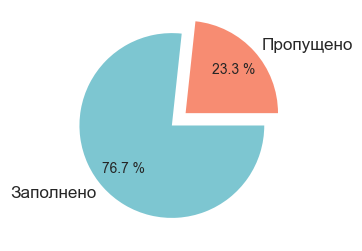

In [628]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['ponds_around3000'], 100 - percent_missing['ponds_around3000']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Оставляем данные без изменений, поскольку для заполнения пропусков в данной переменной требуются большие трудозатраты (значения по этому признаку заполняются на основе картографических данных). Для дальнейшего анализа эти данные использоваться не будут.

13. Расстояние до ближайшего водоема (ponds_nearest)

In [495]:
percent_missing_out('ponds_nearest')

Пропущено 61.6% значений


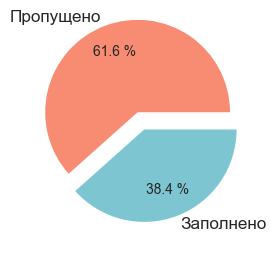

In [629]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['ponds_nearest'], 100 - percent_missing['ponds_nearest']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Оставляем данные без изменений, поскольку для заполнения пропусков в данной переменной требуются большие трудозатраты (значения по этому признаку заполняются на основе картографических данных). Для дальнейшего анализа эти данные использоваться не будут.

14. Длительность размещения объявления (дней от публикации до снятия) (days_exposition)

In [496]:
percent_missing_out('days_exposition')

Пропущено 13.4% значений


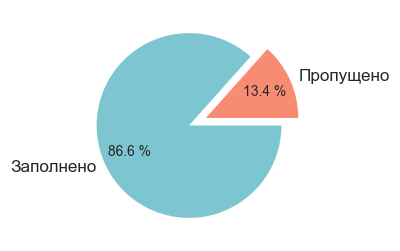

In [630]:
plt.figure(figsize=(3, 3))
plt.pie([percent_missing['days_exposition'], 100 - percent_missing['days_exposition']],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

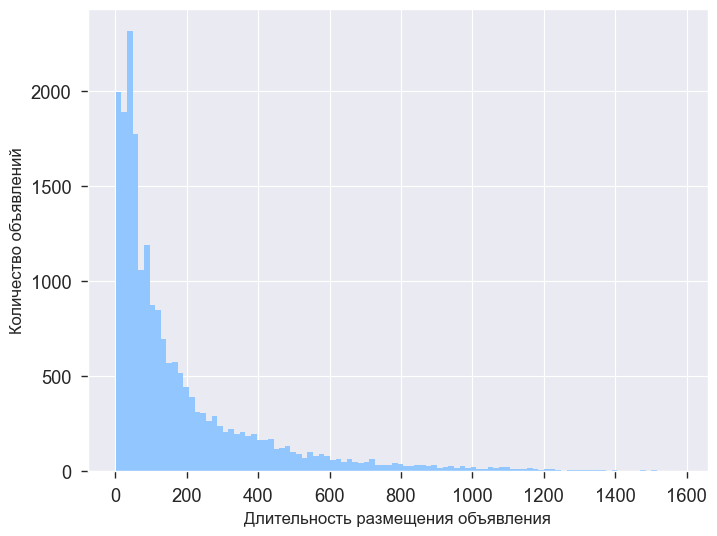

In [497]:
plt.figure(figsize=(8, 6))
plt.hist(data['days_exposition'], bins=100)
plt.xlabel('Длительность размещения объявления', fontsize=12)
plt.ylabel('Количество объявлений', fontsize=12)
plt.show()

In [498]:
data['days_exposition'].median()  # медианное значение длительности размещения объявления

95.0

In [499]:
# замена пропусков на медианное значение
data.loc[data['days_exposition'].isna(), 'days_exposition'] = data['days_exposition'].median()

In [500]:
print(data['days_exposition'].isna().value_counts())

False    23565
Name: days_exposition, dtype: int64


Вывод: Было пропущено 13,4% значений. Пропуски были заменены медианной длительностью размещения объявления.

#### Приведение данных к нужным типам

In [501]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
print(data['first_day_exposition'].head())

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]


Вывод: Тип данных столбца со значениями длительности размещения объявления был заменен со строчного на временной.

### Расчет и добавление новых столбцов в датасет

Расчет цены квадратного метра:

In [502]:
data['price_per_sqm'] = round(data['last_price'] / data['total_area'], 1)
print(data['price_per_sqm'].head())

0    120370.4
1     82920.8
2     92785.7
3    408176.1
4    100000.0
Name: price_per_sqm, dtype: float64


Добавление дня недели, месяца и года публикации объявления:

In [503]:
data['day_of_week'] = data['first_day_exposition'].dt.weekday
data['month'] = data['first_day_exposition'].dt.month
data['year'] = data['first_day_exposition'].dt.year
print(data[['first_day_exposition', 'day_of_week', 'month', 'year']].head())

  first_day_exposition  day_of_week  month  year
0           2019-03-07            3      3  2019
1           2018-12-04            1     12  2018
2           2015-08-20            3      8  2015
3           2015-07-24            4      7  2015
4           2018-06-19            1      6  2018


Добавление этажа квартиры:

In [504]:
data.loc[data['floor'] == 1, 'floor_type'] = 'первый'
data.loc[data['floor'] == data['floors_total'], 'floor_type'] = 'последний'
data.loc[data['floor_type'].isna(), 'floor_type'] = 'другой'
print(data[['floor', 'floors_total', 'floor_type']])

       floor  floors_total floor_type
0          8          16.0     другой
1          1          11.0     первый
2          4           5.0     другой
3          9          14.0     другой
4         13          14.0     другой
...      ...           ...        ...
23694      3           5.0     другой
23695      4           5.0     другой
23696      1           3.0     первый
23697     12          17.0     другой
23698      1           5.0     первый

[23565 rows x 3 columns]


Добавление соотношения жилой и общей площади, а также отношения площади кухни к общей площади

In [505]:
data['living_total_area_ratio'] = data['living_area'] / data['total_area']
data['kitchen_total_area_ratio'] = data['living_area'] / data['total_area']
print(data[['living_total_area_ratio', 'kitchen_total_area_ratio']].head())

   living_total_area_ratio  kitchen_total_area_ratio
0                 0.472222                  0.472222
1                 0.460396                  0.460396
2                 0.612500                  0.612500
3                -1.402968                 -1.402968
4                 0.320000                  0.320000


### Исследовательский анализ данных

In [506]:
plt.style.use('seaborn-pastel')

#### Рассмотрим следующие параметры: площадь, цена, число комнат, высота потолков:

1. Площадь

In [507]:
data['total_area'].describe()

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

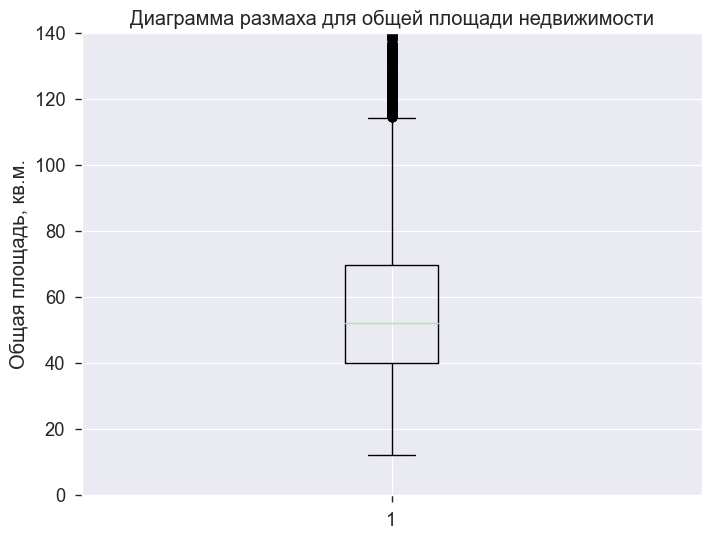

In [508]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['total_area'])
plt.ylim(0, 140)  # ограничение значений площади
plt.title('Диаграмма размаха для общей площади недвижимости')
plt.ylabel('Общая площадь, кв.м.')
plt.show()

Наблюдается большое количество выбросов, от которых необходимо избавиться.

In [509]:
# функция для выявления выбросов в столбце
def is_outlier(series_):
    desc_stats = series_.describe()
    IQR = desc_stats[6] - desc_stats[4]
    lower = desc_stats[4] - 1.5 * IQR  # нижняя допустимая граница
    if lower < desc_stats[3]:
        lower = desc_stats[3]
    upper = desc_stats[6] + 1.5 * IQR  # верхняя допустимая граница
    if upper > desc_stats[7]:
        upper = desc_stats[7]
    return (series_ > upper) | (series_ < lower)

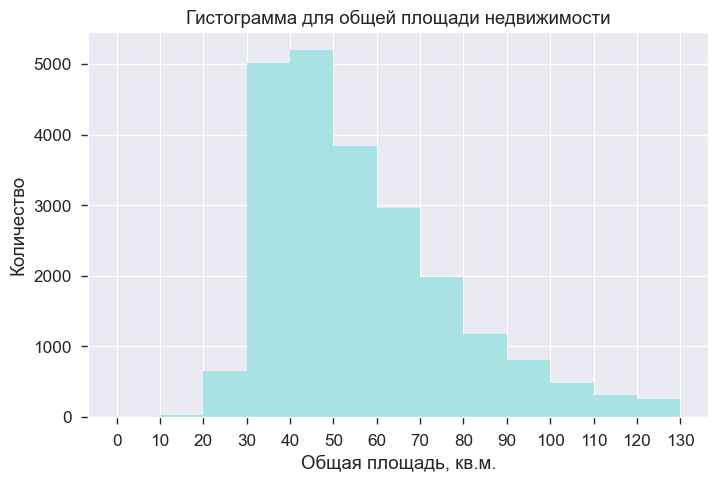

In [577]:
plt.figure(figsize=(8, 5))
bins = np.arange(0, 140, 10).tolist()  # ограничение значений площади
plt.hist(data['total_area'], bins=bins, color='#a8e2e3')
plt.xticks(bins)
plt.title('Гистограмма для общей площади недвижимости')
plt.xlabel('Общая площадь, кв.м.')
plt.ylabel('Количество')
plt.show()

Добавляем столбец, указывающий, какие из наблюдений имеют аномально большую площадь недвижимости.

In [511]:
data['total_area_outlier'] = is_outlier(data['total_area'])
print(data.loc[data['total_area_outlier'] == True, 'total_area'].sort_values().head())

19491    114.30
13686    114.30
1966     114.40
16094    114.50
18273    114.55
Name: total_area, dtype: float64


Вывод: аномальными являются записи с общей площадью объекта недвижимости 113,3 квадратных метра и более.

In [512]:
# функция, считающая долю аномальных значений по логическому столбцу
def percent_outliers(series_):
    print('Процент аномальных значениий: {:.1%}'.format(series_.mean()))

In [513]:
percent_outliers(data['total_area_outlier'])

Процент аномальных значениий: 5.3%


Вывод: в среднем, общая площадь продаваемого объекта недвижимости составляет 52 квадратных метра.

2. Цена

In [514]:
data['last_price'].describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

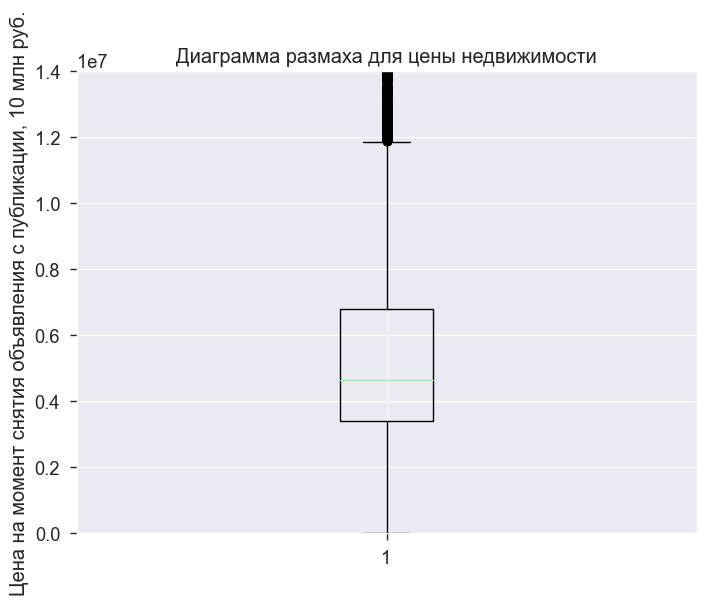

In [515]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['last_price'])
plt.ylim(0, 14000000)  # ограничение значений цены
plt.title('Диаграмма размаха для цены недвижимости')
plt.ylabel('Цена на момент снятия объявления с публикации, 10 млн руб.')
plt.show()

Наблюдается большое количество выбросов, от которых необходимо избавиться.

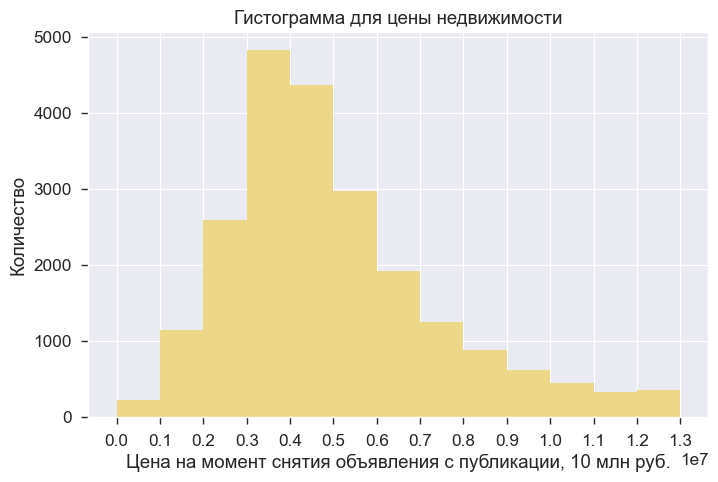

In [578]:
plt.figure(figsize=(8, 5))
bins = np.arange(0, 14000000, 1000000).tolist()  # ограничение значений цены
plt.hist(data['last_price'], bins=bins, color='#edd88a')
plt.xticks(bins)
plt.title('Гистограмма для цены недвижимости')
plt.xlabel('Цена на момент снятия объявления с публикации, 10 млн руб.')
plt.ylabel('Количество')
plt.show()

Добавляем столбец, указывающий, какие из наблюдений имеют аномально большую цену недвижимости.

In [517]:
data['price_outlier'] = is_outlier(data['last_price'])
print(data.loc[data['price_outlier'] == True, 'last_price'].sort_values().head())

20860    11879250.0
13701    11880000.0
17738    11894400.0
3145     11900000.0
22275    11900000.0
Name: last_price, dtype: float64


Вывод: анормальными являются записи с величиной стоимости объекта недвижимости 11879250 рублей и более.

In [518]:
percent_outliers(data['price_outlier'])

Процент аномальных значениий: 8.7%


Вывод: в среднем, цена продаваемого объекта недвижимости составляет 4,65 млн рублей.

3. Число комнат

In [519]:
data['rooms'].describe()

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

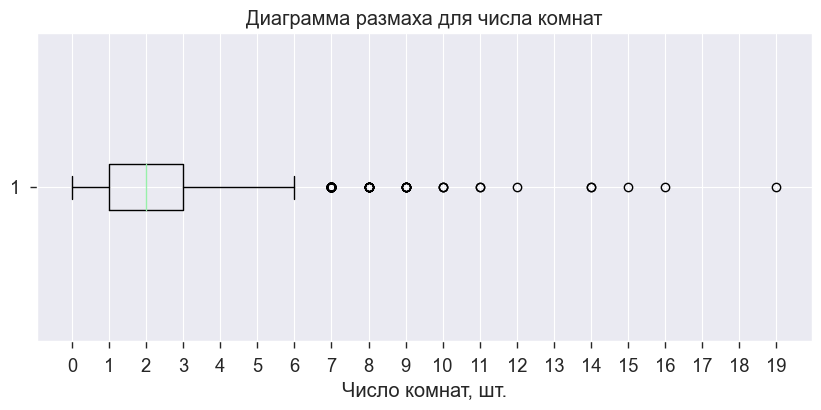

In [520]:
plt.figure(figsize=(10, 4))
plt.boxplot(data['rooms'], vert=False)
plt.xticks(np.arange(0, 20, 1))
plt.title('Диаграмма размаха для числа комнат')
plt.xlabel('Число комнат, шт.')
plt.show()

Выбросов не так много, но от них также необходимо избавиться.

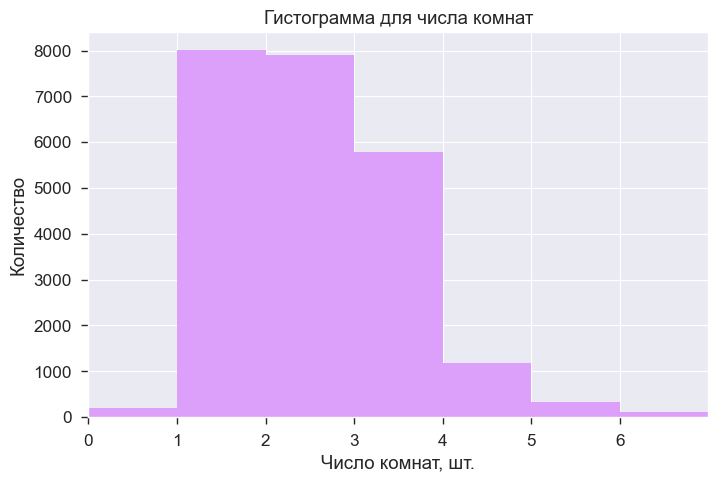

In [579]:
plt.figure(figsize=(8, 5))
bins = np.arange(0, 20, 1).tolist()
plt.hist(data['rooms'], bins=bins, color='#dca0fa')
plt.xlim(0, 7)
plt.xticks(np.arange(0, 7, 1))
plt.title('Гистограмма для числа комнат')
plt.xlabel('Число комнат, шт.')
plt.ylabel('Количество')
plt.show()

Добавляем столбец, указывающий, какие из наблюдений имеют аномально большое число комнат.

In [522]:
data['rooms_outlier'] = is_outlier(data['rooms'])
print(data.loc[data['rooms_outlier'] == True, 'rooms'].sort_values().head())

581      7
8559     7
9889     7
10294    7
23400    7
Name: rooms, dtype: int64


Вывод: аномальными являются записи с числом комнат 7 шт. и более.

In [523]:
percent_outliers(data['rooms_outlier'])

Процент аномальных значениий: 0.4%


Вывод: в среднем, число комнат продаваемого объекта недвижимости составляет 2 шт.

4. Высота потолков

In [524]:
data['ceiling_height'].describe()

count    23565.000000
mean         2.782353
std          0.989365
min          1.000000
25%          2.600000
50%          2.800000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

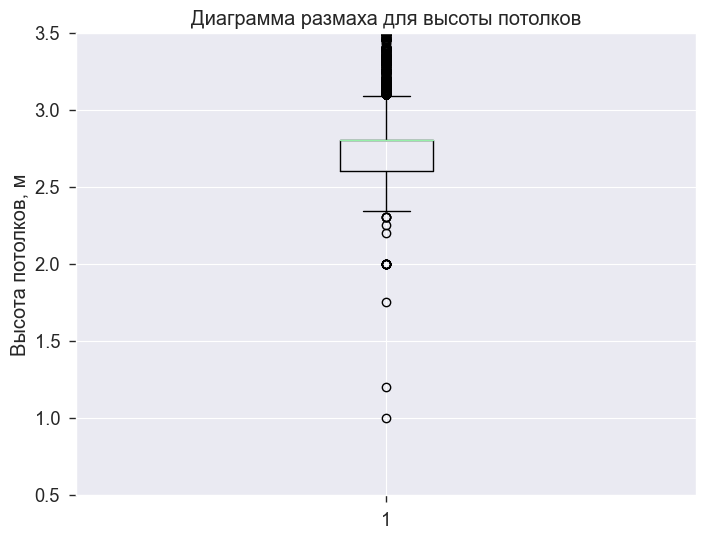

In [525]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['ceiling_height'])
plt.ylim(0.5, 3.5)
plt.title('Диаграмма размаха для высоты потолков')
plt.ylabel('Высота потолков, м')
plt.show()

Наблюдается большое количество выбросов, от которых необходимо избавиться.

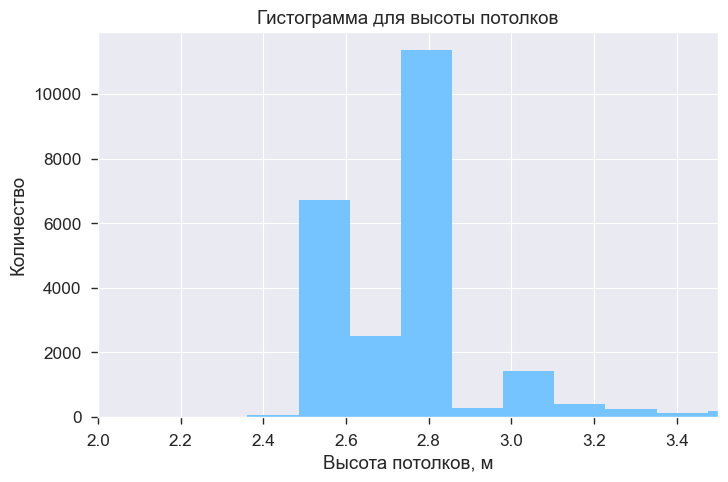

In [580]:
plt.figure(figsize=(8, 5))
plt.hist(data['ceiling_height'], bins=800, color='#75c3ff')
plt.xlim(2, 3.5)
plt.title('Гистограмма для высоты потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество')
plt.show()

Добавляем столбец, указывающий, какие из наблюдений имеют аномально большую или аномально маленькую высоту потолков.

In [527]:
data['ceiling_outlier'] = is_outlier(data['ceiling_height'])
print(data.loc[(data['ceiling_outlier'] == True) & (data['ceiling_height'] < data['ceiling_height'].describe()[4]),
               'ceiling_height'].sort_values(ascending=False).head())
print('\n')
print(data.loc[(data['ceiling_outlier'] == True) & (data['ceiling_height'] > data['ceiling_height'].describe()[6]),
               'ceiling_height'].sort_values().head())

23498    2.30
1582     2.30
5498     2.30
17762    2.30
17794    2.25
Name: ceiling_height, dtype: float64


3865     3.1
14576    3.1
19044    3.1
19043    3.1
19020    3.1
Name: ceiling_height, dtype: float64


Вывод: аномальными являются записи с высотой потолков объекта недвижимости 2,3 метра и менее или 3,1 метра и более.

In [528]:
percent_outliers(data['ceiling_outlier'])

Процент аномальных значениий: 6.1%


Вывод: в среднем, высота потолков продаваемого объекта недвижимости составляет от 2,5 до 2,8 метров.

#### Изучим время продажи квартиры:

In [529]:
data['days_exposition'].describe()

count    23565.000000
mean       169.203692
std        206.497729
min          1.000000
25%         45.000000
50%         95.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

Вывод: в среднем, срок размещения объявления о продаже объекта недвижимости составляет около 3-х месяцев (95 дней).

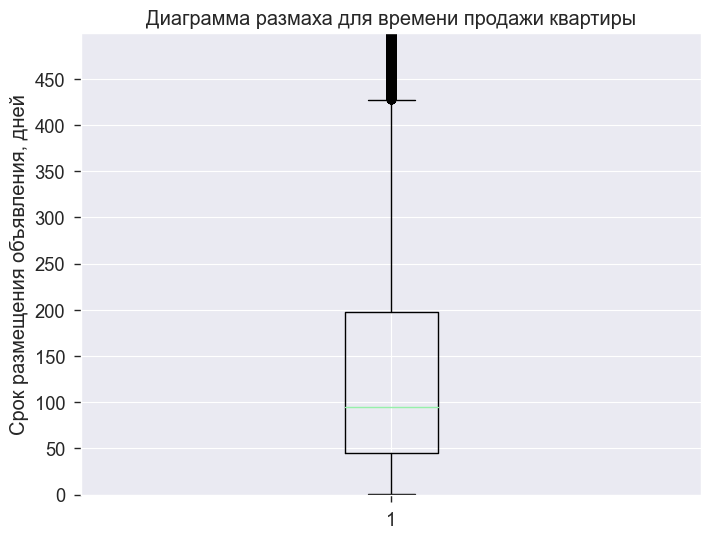

In [530]:
plt.figure(figsize=(8, 6))
plt.boxplot(data['days_exposition'])
plt.ylim(0, 500)
plt.yticks(np.arange(0, 500, 50))
plt.title('Диаграмма размаха для времени продажи квартиры')
plt.ylabel('Срок размещения объявления, дней')
plt.show()

Наблюдается большое количество выбросов, от которых необходимо избавиться.

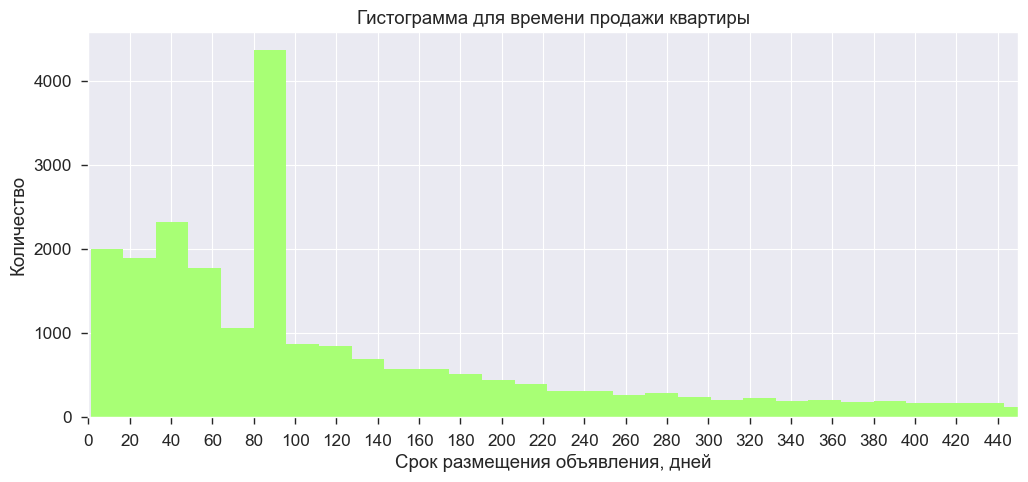

In [581]:
plt.figure(figsize=(12, 5))
plt.hist(data['days_exposition'], bins=100, color='#a8ff75')
plt.xlim(0, 450)
plt.xticks(np.arange(0, 450, 20))
plt.title('Гистограмма для времени продажи квартиры')
plt.xlabel('Срок размещения объявления, дней')
plt.ylabel('Количество')
plt.show()

In [532]:
print(data.loc[is_outlier(data['days_exposition']) == True, 'days_exposition'].sort_values().head())

14046    428.0
1686     428.0
22923    428.0
787      428.0
11501    428.0
Name: days_exposition, dtype: float64


Вывод: аномальными считаются записи, имеющие срок продажи объекта недвижимости 428 дней и более.
Можно считать, что продажа прошла очень быстро, если срок размещения объявления о продаже объекта недвижимости не превышает одного месяца (30 дней).

In [533]:
data['sold_fast'] = data['days_exposition'] > 428
data['sold_slow'] = data['days_exposition'] <= 30

#### Уберем редкие и выбивающиеся значения

In [534]:
cleaned_data = data[(data['total_area_outlier'] == False) &
                 (data['price_outlier'] == False) &
                 (data['rooms_outlier'] == False) &
                 (data['ceiling_outlier'] == False) &
                 (data['sold_fast'] == False) &
                 (data['sold_slow'] == False)].reset_index(drop=True)

print('Процент чистых значений: {:.1%}'.format(len(cleaned_data) / len(data)))

Процент чистых значений: 64.6%


#### Определим факторы, больше всего влияющие на стоимость квартиры

In [535]:
plt.style.use('seaborn-pastel')

1. Зависимость цены от площади, числа комнат, удаленности от центра

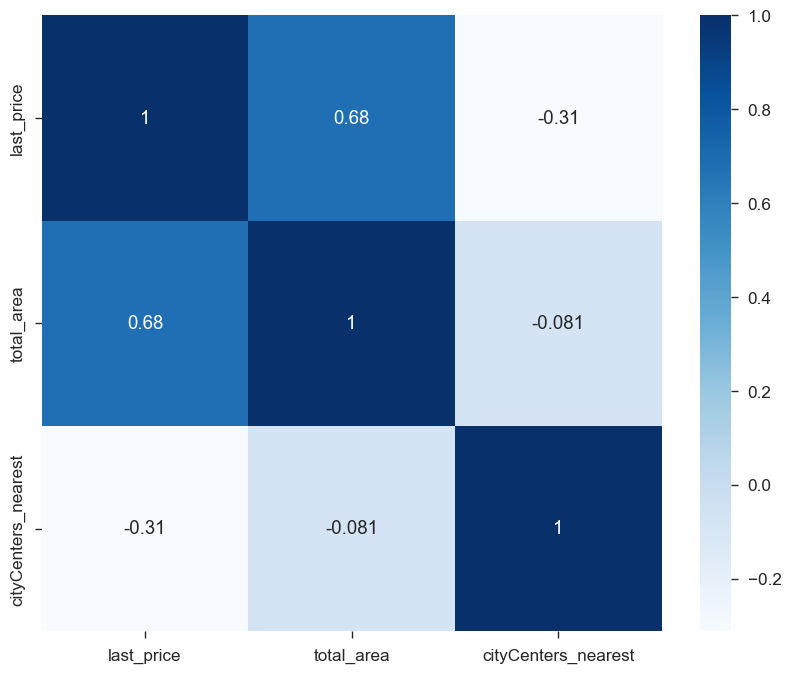

In [536]:
plt.figure(figsize=(10, 8))
sns.set_context('paper', font_scale=1.4)
sns.heatmap(cleaned_data[['last_price', 'total_area', 'cityCenters_nearest']].corr(), annot=True, cmap='Blues')
plt.show()

Вывод: на первый взгляд заметна зависимость цены объекта недвижимости от общей площади (коэффициент корреляции равен 0,68 - прямая линейная зависимость) и расстояния до центра города (коэффициент корреляции равен -0,31 - обратная линейная зависимость). Для зависимости цены от количества комнат коэффициент корреляции проверять не имеет смысла, поскольку число комнат является дискретным факторным признаком.

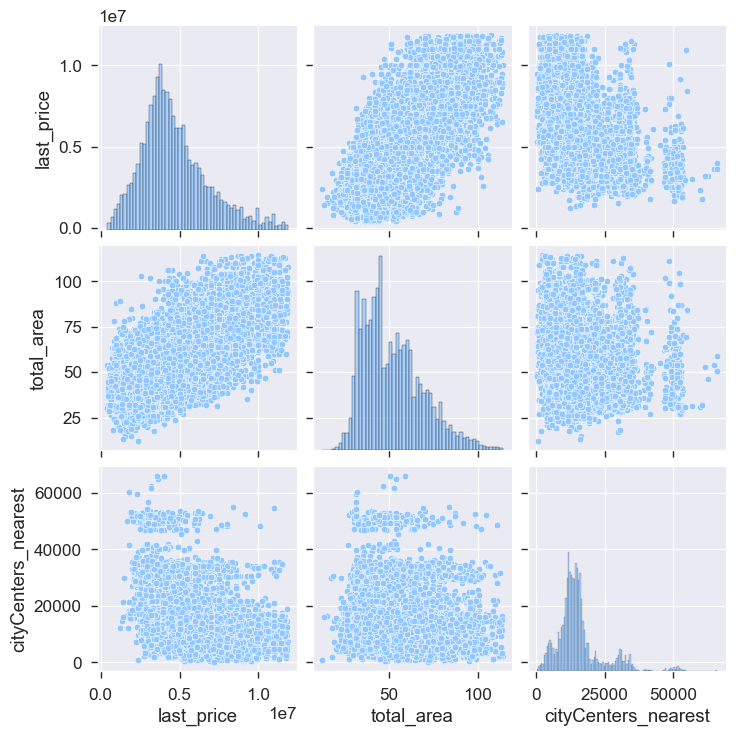

In [537]:
sns.pairplot(cleaned_data[['last_price', 'total_area', 'cityCenters_nearest']])
plt.show()

График, отображающий попарные зависимости признаков, подтверждает предыдущее утверждение.

Исследуем зависимость цены от площади объекта недвижимости:

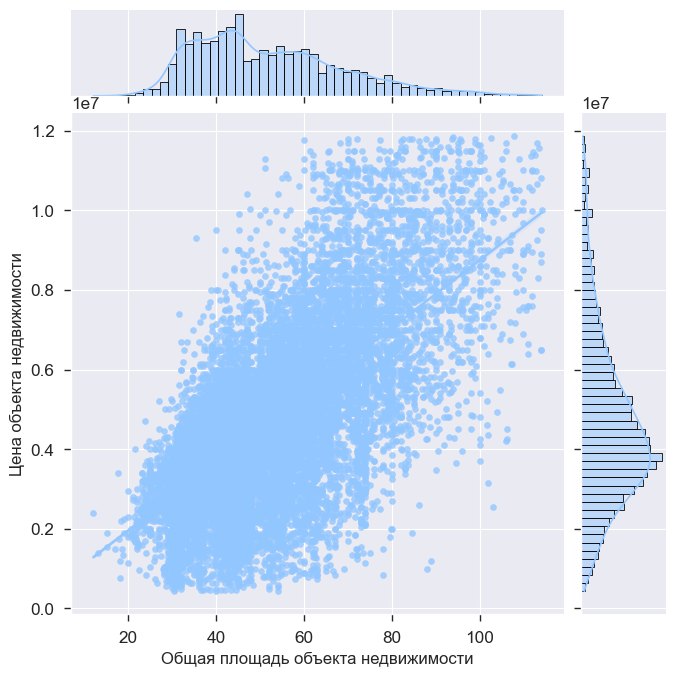

In [538]:
price_tarea_lm = sns.jointplot(x='total_area', y='last_price', data=cleaned_data, kind='reg', height=7)
price_tarea_lm.set_axis_labels('Общая площадь объекта недвижимости', 'Цена объекта недвижимости', fontsize=12)
plt.show()

Вывод: выявлена прямая линейная зависимость цены объекта недвижимости от общей площади, имеющая умеренную силу связи.

Исследуем зависимость цены от рассотяния объекта недвижимости до центра города:

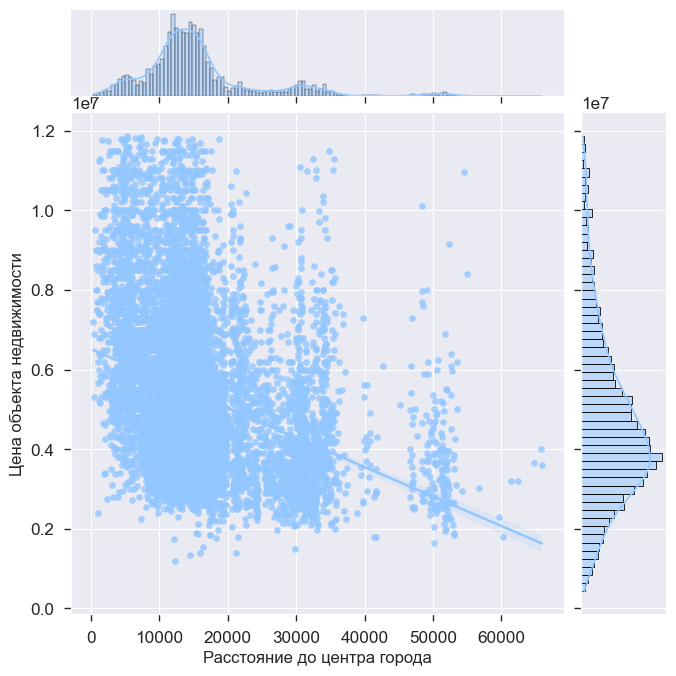

In [539]:
price_tarea_lm = sns.jointplot(x='cityCenters_nearest', y='last_price', data=cleaned_data, kind='reg', height=7)
price_tarea_lm.set_axis_labels('Расстояние до центра города', 'Цена объекта недвижимости', fontsize=12)
plt.show()

Вывод: выявлена обратная линейная зависимость цены объекта недвижимости от расстояния до центра города, имеющая слабую силу связи.

Исследуем зависимость цены от количества комнат:

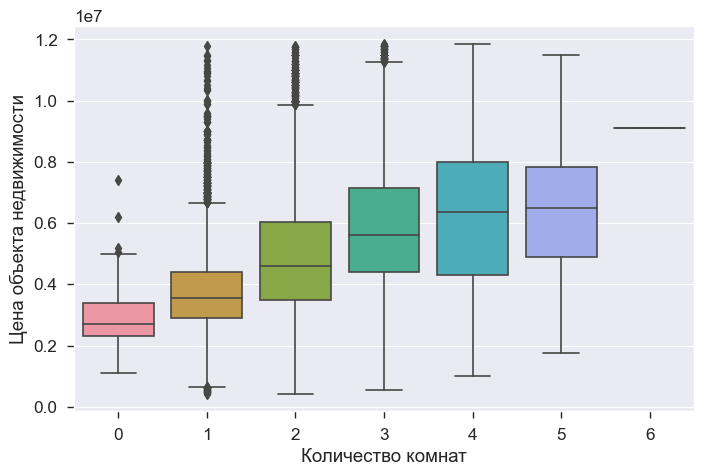

In [540]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='rooms', y='last_price', data=cleaned_data)
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Количество комнат')
plt.show()

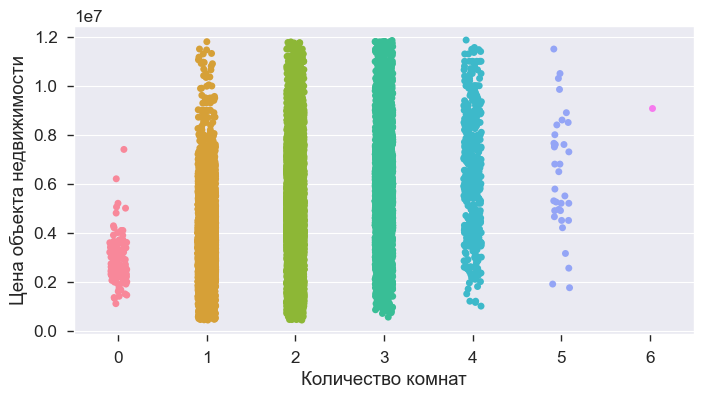

In [541]:
plt.figure(figsize=(8, 4))
sns.stripplot(x='rooms', y='last_price', data=cleaned_data)
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Количество комнат')
plt.show()

Вывод: установлена прямая зависимость цены объекта недвижимости от количества комнат: чем больше в квартире комнат, тем она дороже. Однако также видно, что 4-комнатные квартиры могут быть проданы дешевле 3-комнатных.

2. Зависимость цены от этажа квартиры и от даты размещения объявления: дня недели, месяца и года

Исследуем зависимость цены от этажа квартиры:

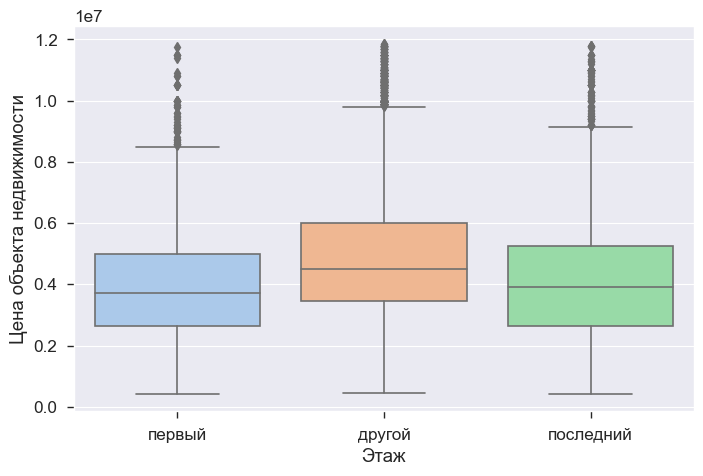

In [542]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='floor_type', y='last_price', data=cleaned_data, palette='pastel')
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Этаж')
plt.show()

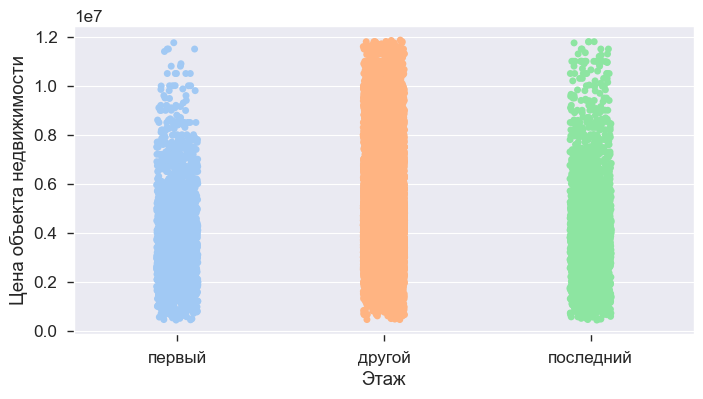

In [543]:
plt.figure(figsize=(8, 4))
sns.stripplot(x='floor_type', y='last_price', data=cleaned_data, palette='pastel')
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Этаж')
plt.show()

In [544]:
print(cleaned_data[['floor_type', 'last_price']].groupby('floor_type').median())

            last_price
floor_type            
другой       4500000.0
первый       3720000.0
последний    3900000.0


Вывод: стоимость квартир, находящихся на первом и последнем этажах, в среднем, меньше стоимости квартир на остальных этажах.

Исследуем зависимость цены от даты размещения объявления:

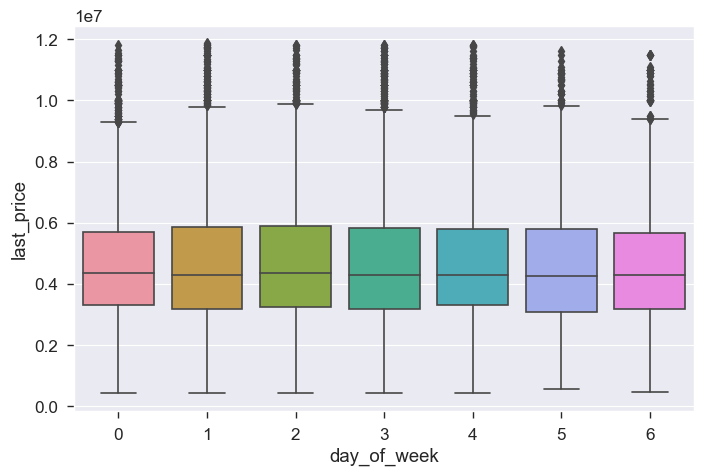

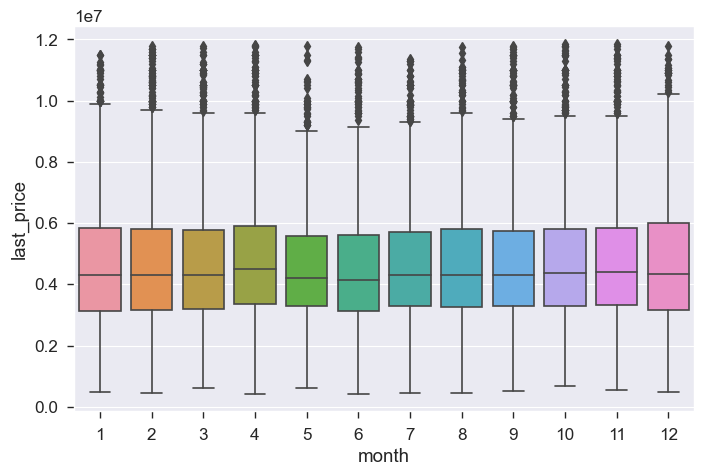

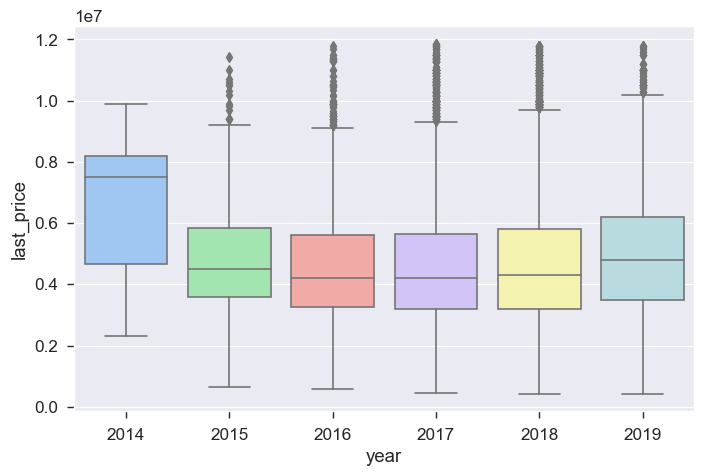

In [545]:
for descr_var in ['day_of_week', 'month', 'year']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=descr_var, y='last_price', data=cleaned_data)
    plt.show()

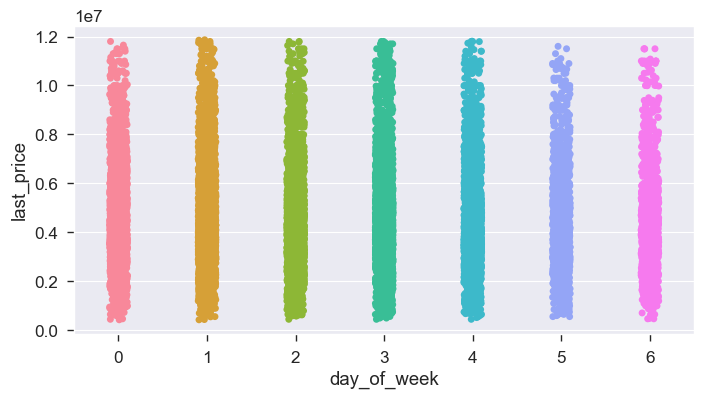

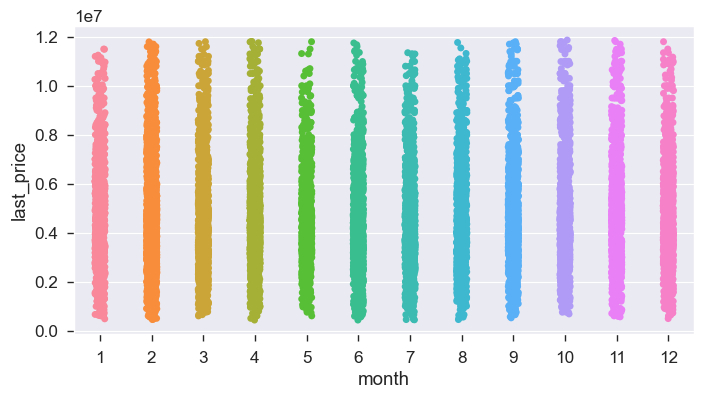

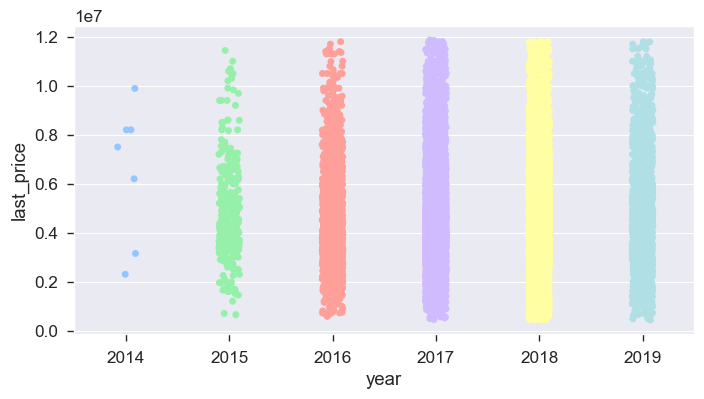

In [546]:
for descr_var in ['day_of_week', 'month', 'year']:
    plt.figure(figsize=(8, 4))
    sns.stripplot(x=descr_var, y='last_price', data=cleaned_data)
    plt.show()

In [547]:
print(data.pivot_table(index='year', values='total_area', aggfunc='count'))  # проверка количества объявлений по годам

      total_area
year            
2014         136
2015        1166
2016        2745
2017        8161
2018        8486
2019        2871


Видим, что за 2014 год количество объявлений мало по сравнению с количеством объявлений за остальные годы. Проверим, даны ли объявления за 2014 год с самого его начала или нет.

In [548]:
data.loc[data['year'] == 2014, 'first_day_exposition'].sort_values().head(1)  # проверка, с какого числа 2014-го года даны данные по объявлениям

10364   2014-11-27
Name: first_day_exposition, dtype: datetime64[ns]

Для объявлений за 2014 год имеем данные только за конец ноября и декабрь. Это может быть связано с тем, что в декабре 2014 года сервис Яндекс.Недвижимость начал принимать объявления от пользователей. Размещать объявление о продаже объектов недвижимости с того момента могут не только партнеры сервиса, но и агентства и частные лица.

Вывод: цена квартиры не зависит от дня недели и месяца публикации объявления о продаже. Однако обнаружено, что в 2014 году продававшиеся квартиры имели, в среднем, более высокую стоимость, чем в последующие года, что обусловлено, скорее всего тем, что сервис Яндекс.Недвижимость сделал свою площадку для размещения объявлениий доступной для всех пользователей только в конце 2014 года, и за 2014-й год число объявлений было малым по сравнению с последующими годами. Поэтому сравнивать среднюю цену на квартиры за 2014-й год с ценой за последующие года не имеет смысла.

#### Проведем анализ по 10 населенным пунктам с наибольшим числом объявлений

Найдем среднюю цену квадратного метра по 10 населенным пунктам с наибольшим числом объявлений:

In [549]:
top10_locality = cleaned_data.pivot_table(index='locality_name', values='price_per_sqm', aggfunc=['count', 'mean'])
top10_locality.columns = ['ads_num', 'mean_price']
top10_locality = top10_locality.sort_values('ads_num', ascending=False).head(10)
print(top10_locality)

                   ads_num     mean_price
locality_name                            
Санкт-Петербург       9266  105521.465023
посёлок Мурино         361   85437.912188
посёлок Шушары         329   79000.018541
Всеволожск             312   67487.738141
Пушкин                 247   99669.022672
посёлок Парголово      245   89799.901224
Колпино                237   74915.146414
Гатчина                227   68459.455507
деревня Кудрово        211   92927.818009
Выборг                 173   57602.461850


In [550]:
print(top10_locality.query('(mean_price == mean_price.max()) | (mean_price == mean_price.min())'))

                 ads_num     mean_price
locality_name                          
Санкт-Петербург     9266  105521.465023
Выборг               173   57602.461850


Вывод: самая высокая стоимость жилья в Санкт-Петербурге, самая низкая - в Выборге.

#### Изучим предложения квартир

In [551]:
SP_missing_percentage = round(len(data[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'].isna())]) /
                              len(data.query('locality_name == "Санкт-Петербург"')), 3)
print(SP_missing_percentage * 100, '%', sep='')  # процент пропущенных значений расстояния до
                                                 # центра для квартир из Санкт-Петербурга

0.4%


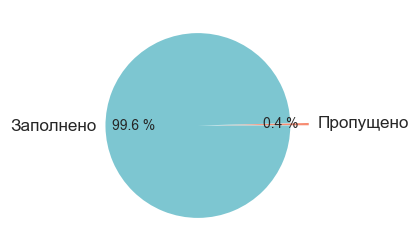

In [631]:
plt.figure(figsize=(3, 3))
plt.pie([SP_missing_percentage * 100, 100 - SP_missing_percentage * 100],
        labels=['Пропущено', 'Заполнено'],
        colors=['#f78c72', '#7dc6d1'],
        autopct='%.1f %%',
        pctdistance=0.7,
        explode=(0.2, 0))
plt.style.use('ggplot')
plt.show()

Из всех объектов недвижимости Санкт-Петербурга в исходных данных отсутствует информация по расстоянию до центра города для 0,4% квартир. Процент не велик, поэтому можем исключить из рассмотрения записи с пропусками.

Выделим квартиры в Санкт-Петербурге:

In [552]:
cleaned_data['cityCenter_distanceKM'] = round(cleaned_data['cityCenters_nearest'] / 1000, 0)
saintP_data = cleaned_data.query('locality_name == "Санкт-Петербург"')
saintP_price_per_km = saintP_data.pivot_table(index='cityCenter_distanceKM', values='last_price', aggfunc='median')
print(saintP_price_per_km.head())  # медианная цена для каждого километра

                       last_price
cityCenter_distanceKM            
0.0                     6900000.0
1.0                     7750000.0
2.0                     8200000.0
3.0                     7435000.0
4.0                     7040000.0


Построим график зависимости цены от удаленности от центра:

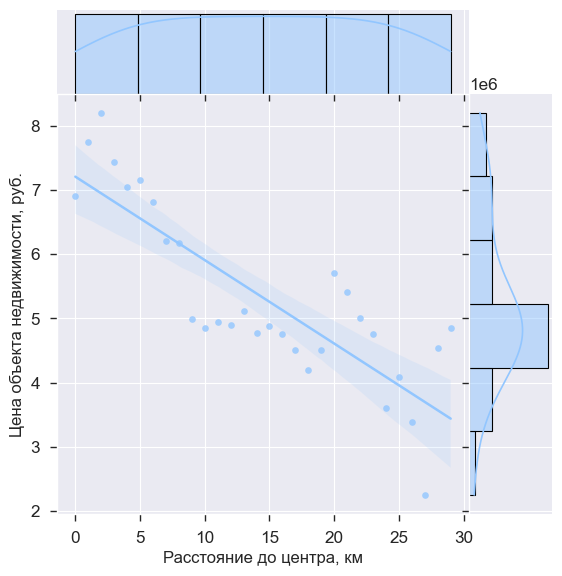

In [553]:
price_CCdistanceKM_lm = sns.jointplot(x=saintP_price_per_km.index, y='last_price', data=saintP_price_per_km, kind='reg', space=0, height=6)
price_CCdistanceKM_lm.set_axis_labels('Расстояние до центра, км', 'Цена объекта недвижимости, руб.', fontsize=12)
plt.show()

Вывод: выявлена обратная линейная зависимость цены квартир от расстояния до центра Санкт-Петербурга. График сильно меняется в промежутке между 8-ым и 9-ым километрами: разница медианных значений цены составляет больше 1 миллиона рублей. Центром Санкт-Петербурга можно считать зону с радиусом 8 км.

#### Изучим сегмент квартир в центре Санкт-Петербурга

In [554]:
saintP_center = cleaned_data.query("(cityCenter_distanceKM < 9) & (locality_name == 'Санкт-Петербург')")

In [555]:
saintP_center['days_exposition'].describe()

count    1458.000000
mean      139.651578
std        95.850959
min        31.000000
25%        70.000000
50%        95.000000
75%       185.000000
max       426.000000
Name: days_exposition, dtype: float64

Вывод: средний срок продажи квартиры в центре Санкт-Петербурга составляет 95 дней.

Изучим следующие параметры: площадь, цену, число комнат и высоту потолков квартир

1. Площадь

In [556]:
saintP_center['total_area'].describe()

count    1458.000000
mean       61.457606
std        20.025626
min        12.000000
25%        45.200000
50%        60.000000
75%        75.000000
max       114.200000
Name: total_area, dtype: float64

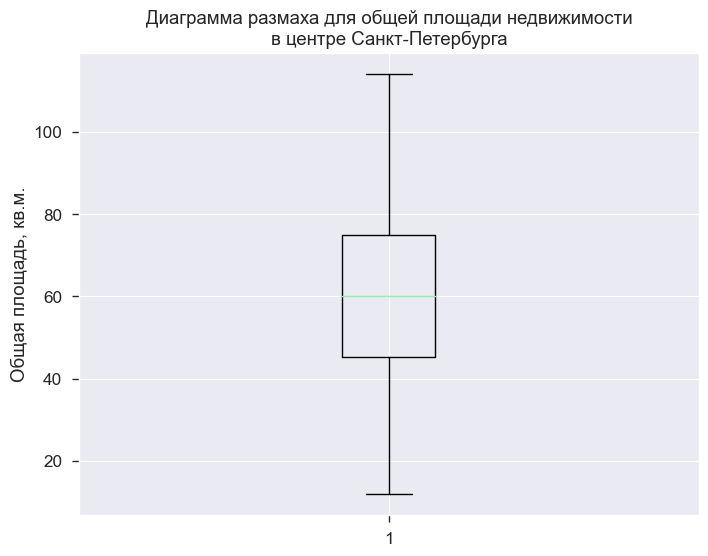

In [557]:
plt.figure(figsize=(8, 6))
plt.boxplot(saintP_center['total_area'])
plt.title('Диаграмма размаха для общей площади недвижимости\nв центре Санкт-Петербурга')
plt.ylabel('Общая площадь, кв.м.')
plt.show()

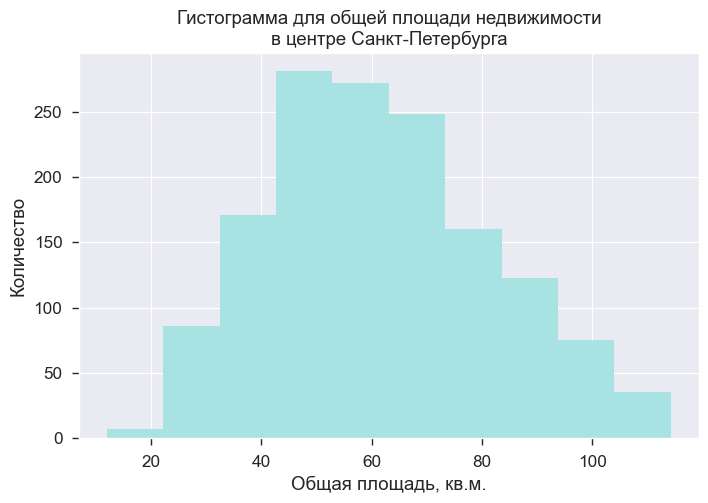

In [582]:
plt.figure(figsize=(8, 5))
plt.hist(saintP_center['total_area'], color='#a8e2e3')
plt.title('Гистограмма для общей площади недвижимости\nв центре Санкт-Петербурга')
plt.xlabel('Общая площадь, кв.м.')
plt.ylabel('Количество')
plt.show()

Вывод: в среднем, квартира, находящаяся в центре Санкт-Петербурга, имеет площадь 60 кв. м.

2. Цена объекта недвижимости

In [559]:
saintP_center['last_price'].describe()

count    1.458000e+03
mean     7.075856e+06
std      2.169368e+06
min      2.250000e+06
25%      5.400000e+06
50%      6.889500e+06
75%      8.640533e+06
max      1.186686e+07
Name: last_price, dtype: float64

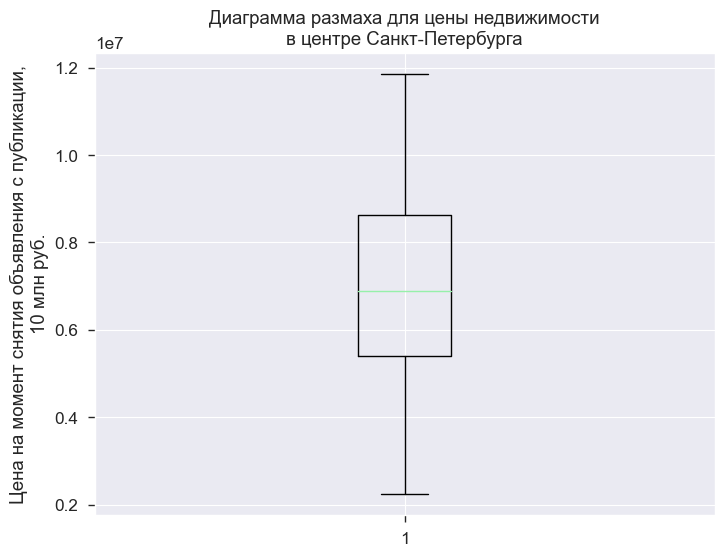

In [560]:
plt.figure(figsize=(8, 6))
plt.boxplot(saintP_center['last_price'])
plt.title('Диаграмма размаха для цены недвижимости\nв центре Санкт-Петербурга')
plt.ylabel('Цена на момент снятия объявления с публикации,\n10 млн руб.')
plt.show()

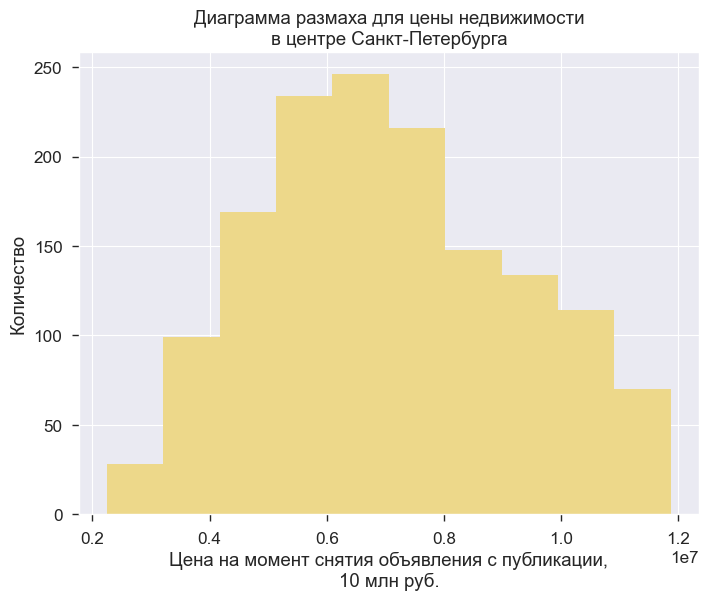

In [583]:
plt.figure(figsize=(8, 6))
plt.hist(saintP_center['last_price'], color='#edd88a')
plt.title('Диаграмма размаха для цены недвижимости\nв центре Санкт-Петербурга')
plt.xlabel('Цена на момент снятия объявления с публикации,\n10 млн руб.')
plt.ylabel('Количество')
plt.show()

Вывод: в среднем, квартира в центре Санкт-Петербурга стоит около 6,9 миллионов рублей.

3. Число комнат

In [562]:
saintP_center['rooms'].describe()

count    1458.000000
mean        2.164609
std         0.924944
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

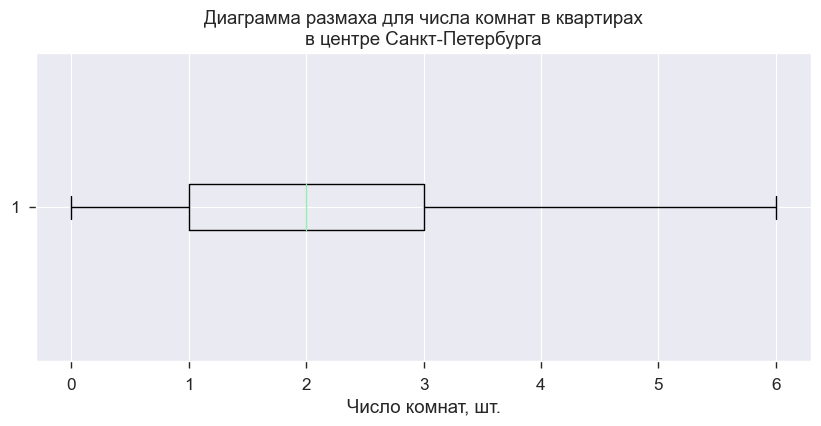

In [563]:
plt.figure(figsize=(10, 4))
plt.boxplot(saintP_center['rooms'], vert=False)
plt.title('Диаграмма размаха для числа комнат в квартирах\nв центре Санкт-Петербурга')
plt.xlabel('Число комнат, шт.')
plt.show()

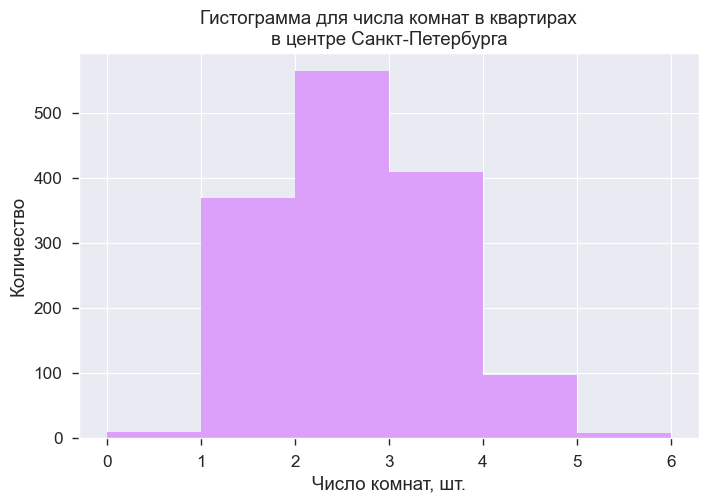

In [584]:
plt.figure(figsize=(8, 5))
plt.hist(saintP_center['rooms'], bins=6, color='#dca0fa')
plt.title('Гистограмма для числа комнат в квартирах\nв центре Санкт-Петербурга')
plt.xlabel('Число комнат, шт.')
plt.ylabel('Количество')
plt.show()

Вывод: в среднем, в центре Санкт-Петербурга продаются 2х-комнатные квартиры.

4. Высота потолков

In [565]:
saintP_center['ceiling_height'].describe()

count    1458.000000
mean        2.796077
std         0.140429
min         2.400000
25%         2.760000
50%         2.800000
75%         2.800000
max         3.090000
Name: ceiling_height, dtype: float64

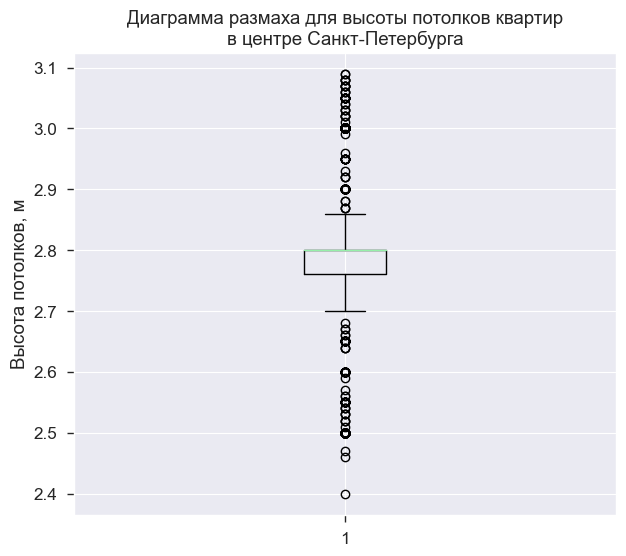

In [566]:
plt.figure(figsize=(7, 6))
plt.boxplot(saintP_center['ceiling_height'])
plt.title('Диаграмма размаха для высоты потолков квартир\nв центре Санкт-Петербурга')
plt.ylabel('Высота потолков, м')
plt.show()

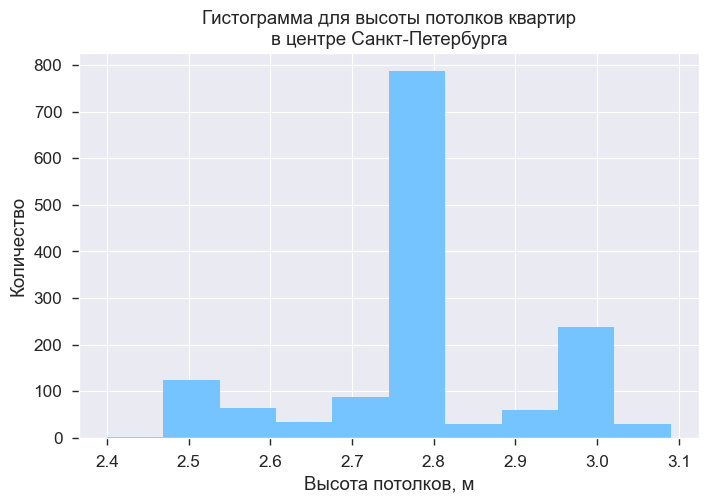

In [585]:
plt.figure(figsize=(8, 5))
plt.hist(saintP_center['ceiling_height'], color='#75c3ff')
plt.title('Гистограмма для высоты потолков квартир\nв центре Санкт-Петербурга')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество')
plt.show()

Вывод: в среднем, высота потолков продаваемых в центре Санкт-Петербурга квартир составляет 2,75 метров.

Выделим факторы, которые влияют на стоимость квартиры в центре Санкт-Петербурга:

1. Количество комнат

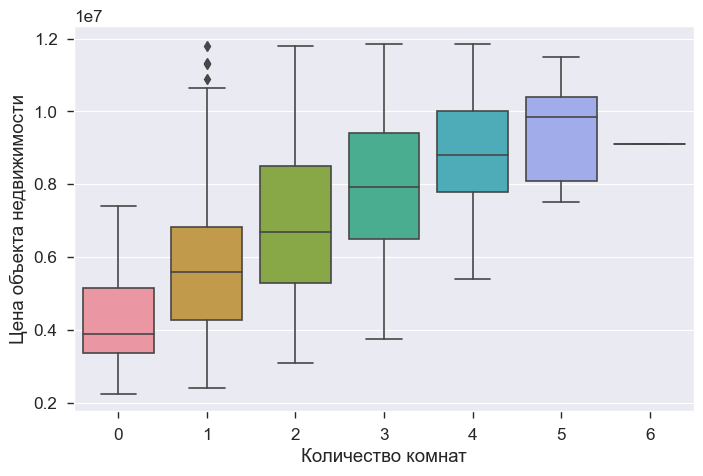

In [568]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='rooms', y='last_price', data=saintP_center)
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Количество комнат')
plt.show()

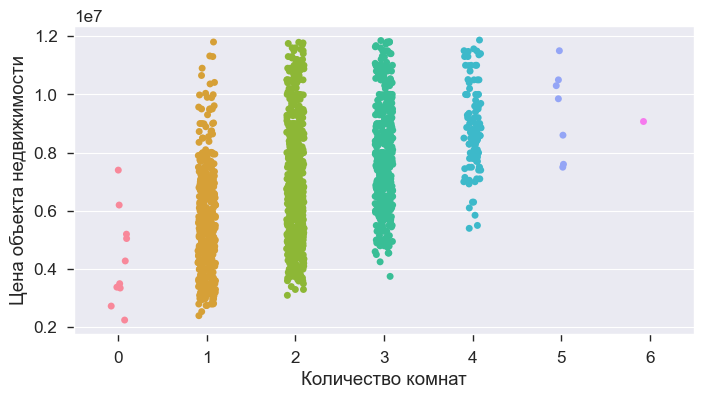

In [569]:
plt.figure(figsize=(8, 4))
sns.stripplot(x='rooms', y='last_price', data=saintP_center)
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Количество комнат')
plt.show()

Вывод: установлена прямая зависимость цены квартиры в центре Санкт-Петербурга от количества комнат: чем больше в квартире комнат, тем она дороже.

2. Этаж

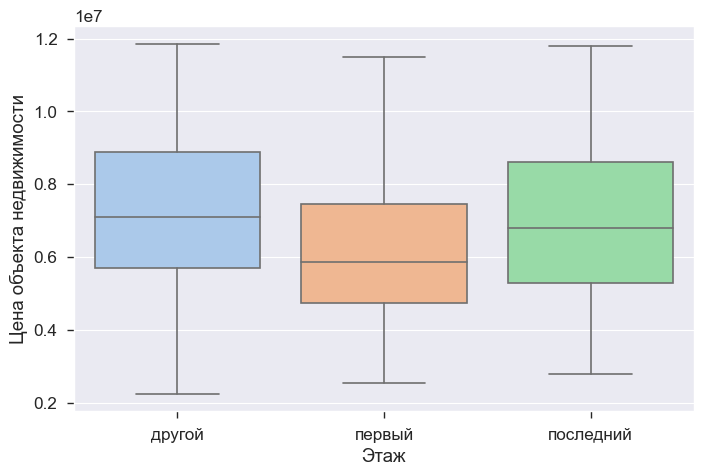

In [570]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='floor_type', y='last_price', data=saintP_center, palette='pastel')
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Этаж')
plt.show()

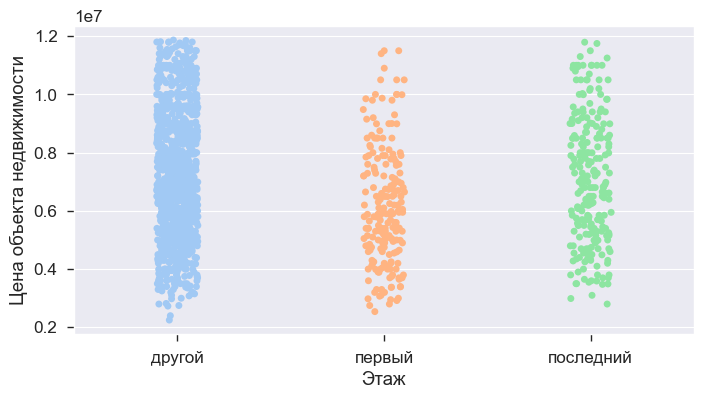

In [571]:
plt.figure(figsize=(8, 4))
sns.stripplot(x='floor_type', y='last_price', data=saintP_center, palette='pastel')
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Этаж')
plt.show()

In [572]:
print(saintP_center[['floor_type', 'last_price']].groupby('floor_type').median())

            last_price
floor_type            
другой       7100000.0
первый       5875000.0
последний    6800000.0


Вывод: в Санкт-Петербурге стоимость квартир, находящихся на первом этаже, в среднем, меньше стоимости квартир на остальных этажах. Средняя стоимость квартир на последних этажах практически не отличается от средней стоимости квартир на других этажах, кроме 1-го.

3. Удаленность от центра

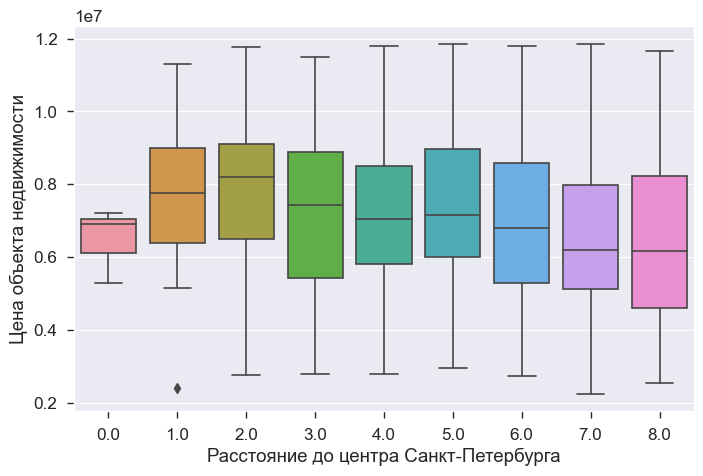

In [573]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='cityCenter_distanceKM', y='last_price', data=saintP_center)
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Расстояние до центра Санкт-Петербурга')
plt.show()

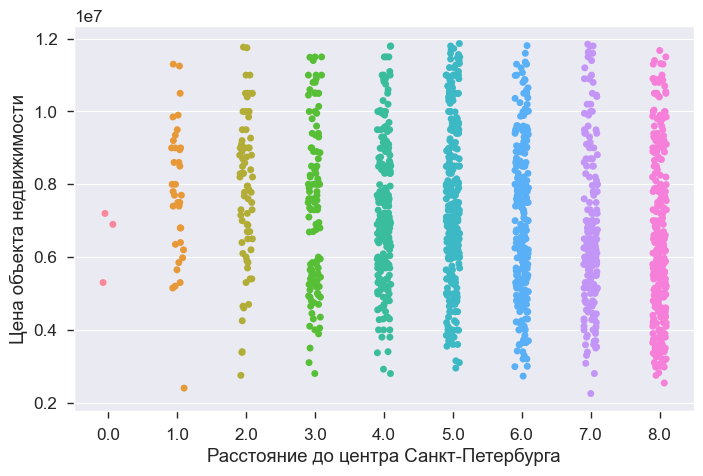

In [574]:
plt.figure(figsize=(8, 5))
sns.stripplot(x='cityCenter_distanceKM', y='last_price', data=saintP_center)
plt.ylabel('Цена объекта недвижимости')
plt.xlabel('Расстояние до центра Санкт-Петербурга')
plt.show()

Вывод: чем дальше квартира находится от центра Санкт-Петербурга, тем, в среднем, дороже будет её стоимость. Однако видно также, что в 4 км от центра можно купить квартиру дешевле, чем в 5 км, а также что в 1 км от центра можно купить квартиру дешевле, чем в 2 км от центра. Видно также, что в самом центре Санкт-Петербурга стоимость квартир меньше стоимости квартир в радиусе от 1 км до 3 км от центра, однако это обусловлено тем, что с уменьшением расстояния от центра города уменьшается количество предложений по продаже квартир на данном расстоянии.

4. Дата размещения объявления

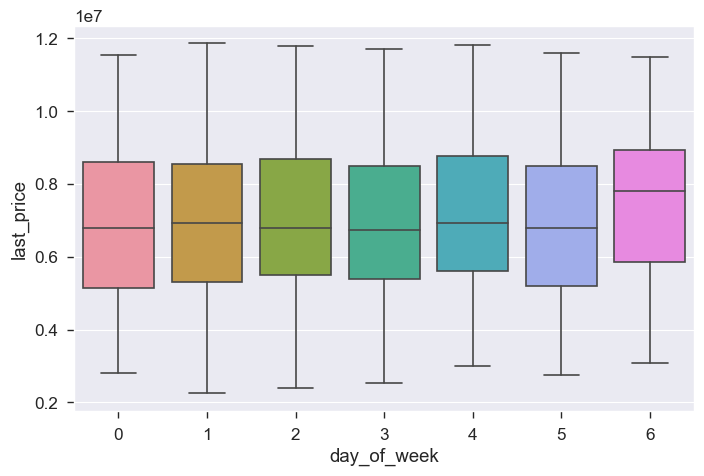

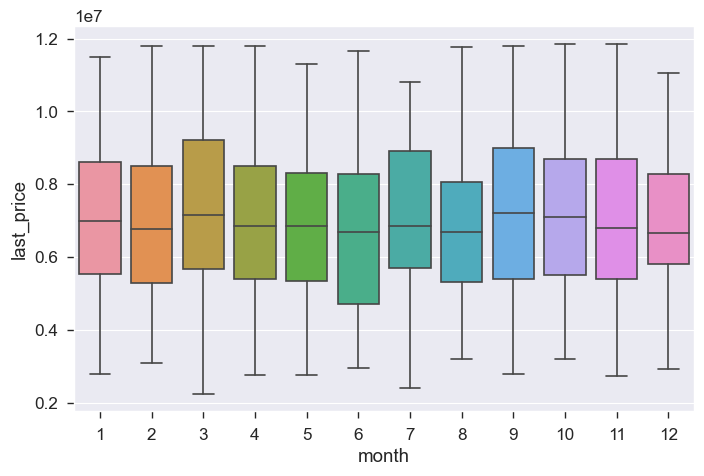

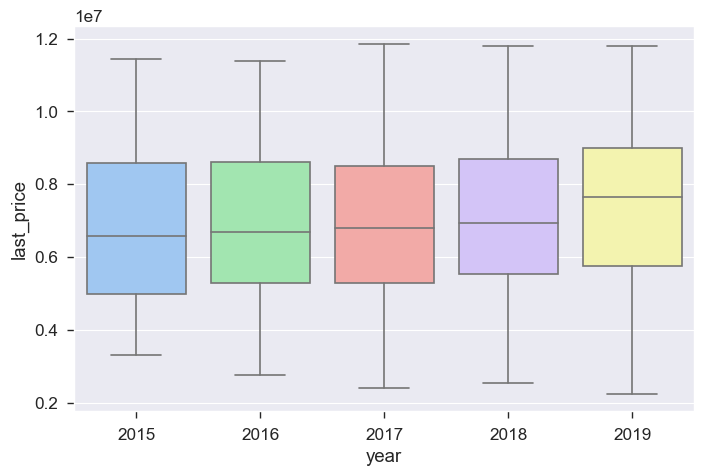

In [575]:
for descr_var in ['day_of_week', 'month', 'year']:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=descr_var, y='last_price', data=saintP_center)
    plt.show()

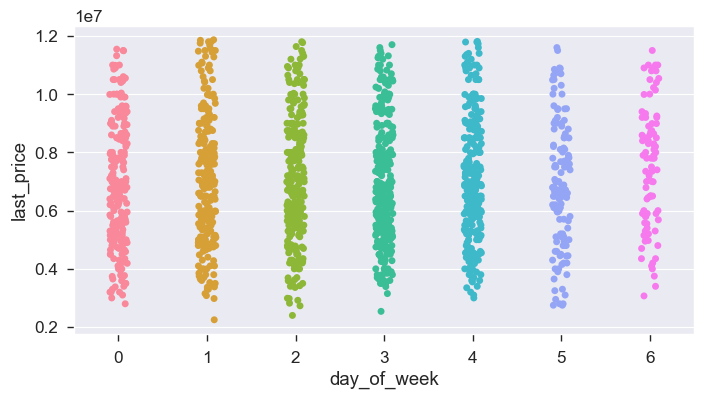

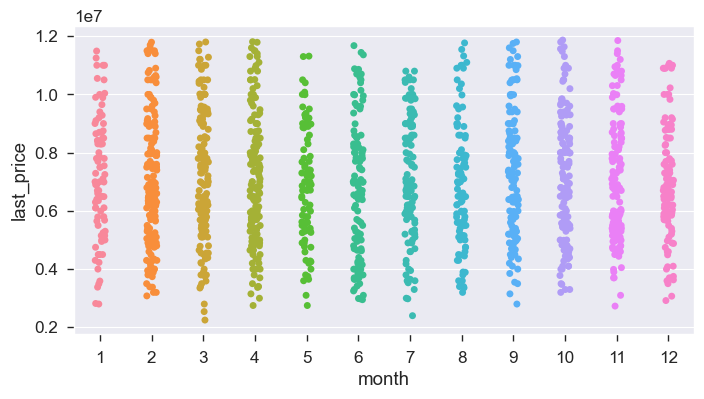

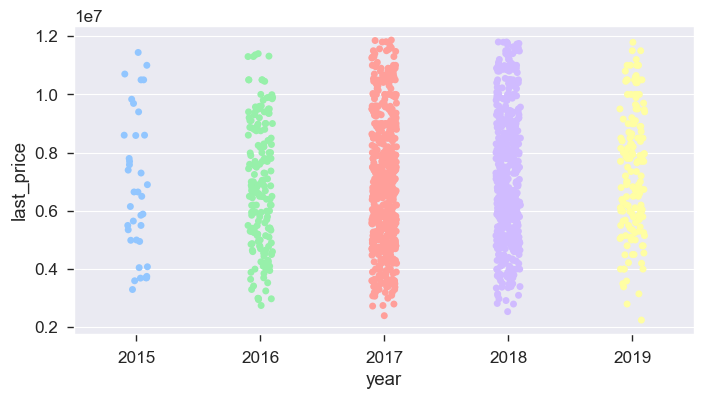

In [576]:
for descr_var in ['day_of_week', 'month', 'year']:
    plt.figure(figsize=(8, 4))
    sns.stripplot(x=descr_var, y='last_price', data=saintP_center)
    plt.show()

Вывод: выявлено, что стоимость квартир в Санкт-Петербурге не зависит от дня публикации объявления о продаже (медианная цена в воскресенье больше по сравнению с ценами в другие дни, поскольку можно наблюдать, что в воскресенье публикуется меньшее число объявлений, чем в другие дни) и месяца публикации объявления о продаже. Также можно наблюдать постепенное повышение цен на квартиры в Санкт-Петербурге с каждым годом. В 2019 году средняя цена на квартиры в Санкт-Петербурге заметно увеличилась по сравнению с предшествующими годами анализируемого периода времени.

### Сравнение результатов анализа по всей базе и по Санкт-Петербургу

Вывод по всей базе:
    В среднем, квартира, выставленная на продажу, обладает следующими признаками: 2х-комнатная квартира общей площадью 52 кв. м с высотой полотков от 2,5 до 2,8 м стоимостью 4,65 млн рублей, проданная за 95 дней.
    При этом факторами, наиболее сильно влияющими на стоимость квартиры, являются: общая площадь объекта недвижимости, расстояние до центра города, количество комнат, этаж, год публикации объявления о продаже.

Вывод по квартирам в центре Санкт-Петербурга:
    В среднем, квартира выставленная на продажу в центре Санкт-Петербурга, обладает следующими признаками: 2х-комнатная квартира общей площадью 60 кв. м с высотой потолков 2,75 м стоимостью 6,9 млн рублей, проданная за 95 дней.
    При этом факторами, наиболее сильно влияющими на стоимость квартиры, являются: общая площадь объекта недвижимости, расстояние до центра города, количество комнат, этаж, год публикации объявления о продаже.


### Общий вывод

Для определения рыночной стоимости объектов недвижимости в Санкт-Петербурге и соседних населенных пунктах необходимо учитывать следующие параметры:
1. общая площадь объекта недвижимости;
2. расстояние до центра города;
3. количество комнат в квартире;
4. этаж квартиры;
5. время продажи квартиры (зависит от макроэкономических показателей страны в период продажи).